# Initializations

## imports

In [19]:
from torchvision.datasets import MNIST
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import torch
import torchvision
from torch.autograd import Variable
import pickle
import seaborn as sns
import numpy as np

from tqdm import tqdm

## configs

In [2]:
batch_size_train = 128
batch_size_test = 100
random_seed = 12453211

imbalanced_weights = {
    0: 0.1,
    1: 0.1,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 0.1,
    6: 1.0,
    7: 0.1,
    8: 1.0,
    9: 1.0
}

#2 → 7, 3 → 8, 5 ↔ 6 and 7 → 1 from SL paper
# Creating asymettric noise for 0,3,4 and 8
asymmetric_noise = {
    0: 0,
    1: 1,
    2: 7,
    3: 8,
    4: 4,
    5: 6,
    6: 5,
    7: 1,
    8: 8,
    9: 9
}

torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Data Preparation

## Loading torch dataset

In [3]:

train_set = torchvision.datasets.MNIST(
    '.',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_set = torchvision.datasets.MNIST(
    '.',
    train=False, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])
)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

bal_train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size_train,
    shuffle=True
)

bal_valid_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size_train,
    shuffle=True,
)

bal_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size_test,
    shuffle=False
)

## loading numpy dataset

In [4]:
def data_loader_to_numpy(data_loader):
    result_x = []
    result_y = []
    for x, y in data_loader:
        result_x.append(x.numpy())
        result_y.append(y.numpy())
        
    return np.concatenate(result_x, axis=0), np.concatenate(result_y, axis=0)
    
train_x, train_y = data_loader_to_numpy(bal_train_loader)
test_x, test_y = data_loader_to_numpy(bal_test_loader)
valid_x, valid_y = data_loader_to_numpy(bal_valid_loader)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(50000, 1, 28, 28) (10000, 1, 28, 28) (50000,) (10000,)


## distribution of classes

<AxesSubplot:ylabel='Count'>

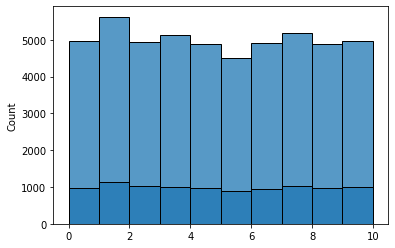

In [5]:
sns.histplot(train_y, bins=[i for i in range(11)])
sns.histplot(test_y, bins=[i for i in range(11)])

<AxesSubplot:>

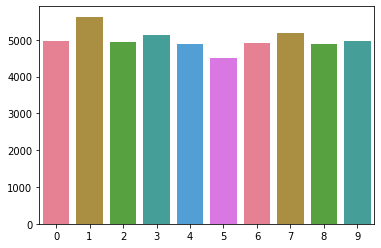

In [6]:
from collections import Counter

train_classes = [label for _, label in train_set]
data_count = Counter(train_classes)
palette = sns.color_palette("husl")
sns.barplot(x=list(data_count.keys()),y=list(data_count.values()),palette=palette)

tensor(3)


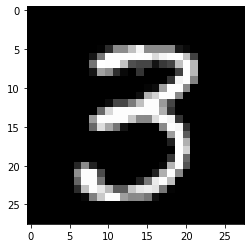

tensor(5)


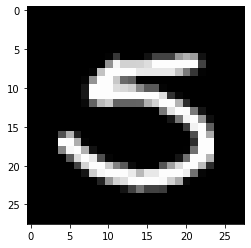

tensor(9)


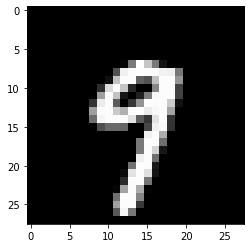

tensor(5)


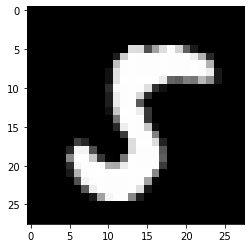

tensor(6)


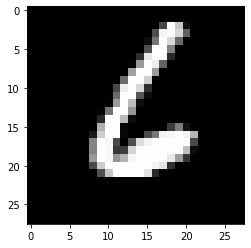

tensor(2)


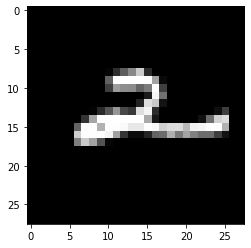

tensor(0)


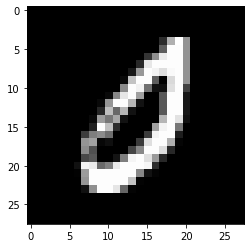

tensor(8)


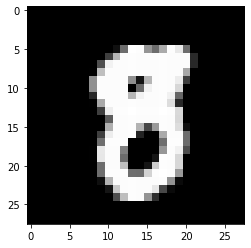

tensor(0)


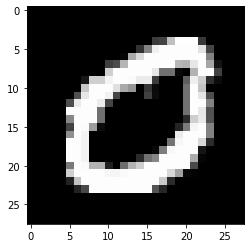

tensor(2)


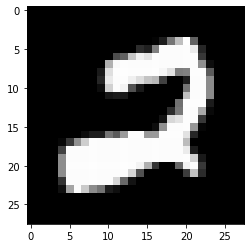

tensor(9)


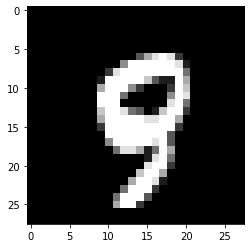

tensor(7)


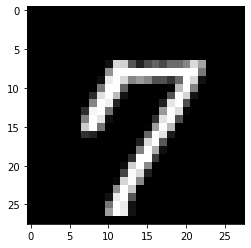

tensor(4)


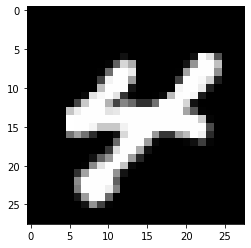

tensor(2)


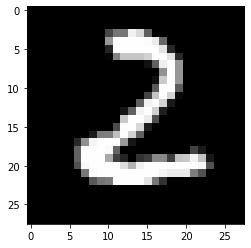

tensor(2)


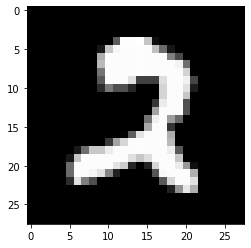

tensor(3)


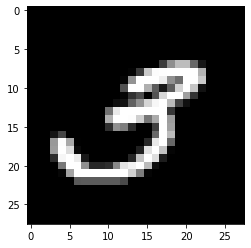

tensor(7)


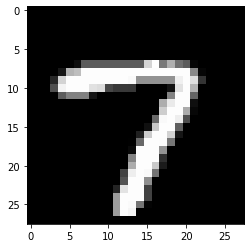

tensor(3)


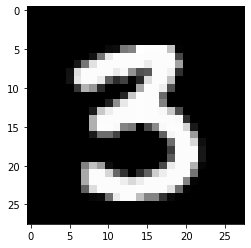

tensor(3)


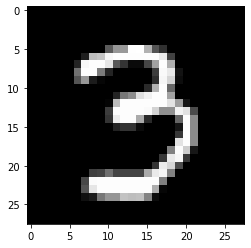

tensor(0)


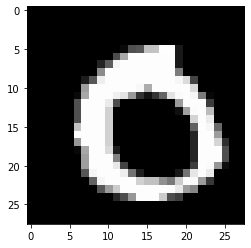

tensor(6)


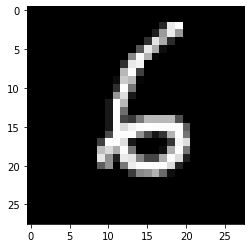

tensor(9)


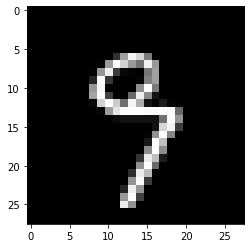

tensor(9)


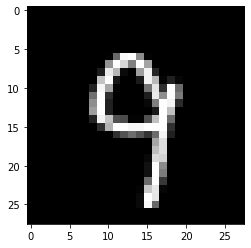

tensor(0)


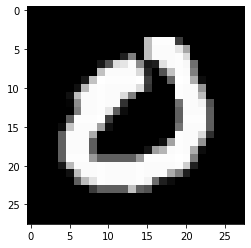

tensor(8)


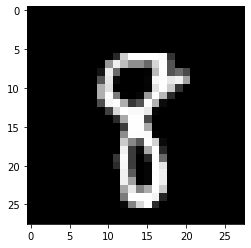

tensor(6)


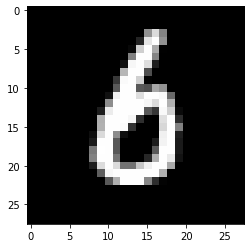

tensor(7)


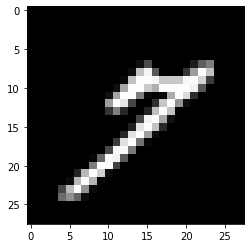

tensor(3)


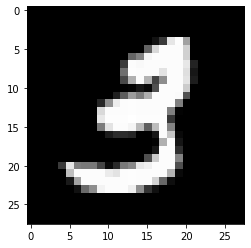

tensor(5)


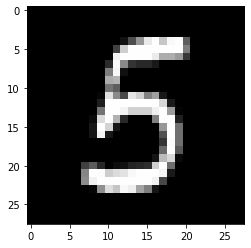

tensor(5)


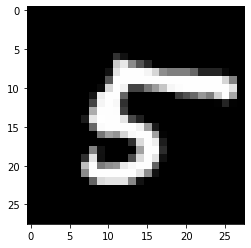

tensor(4)


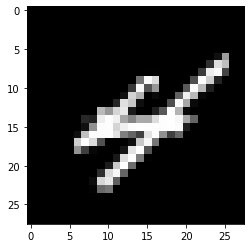

tensor(6)


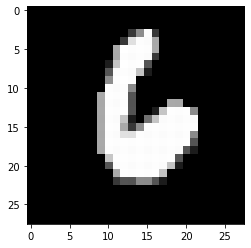

tensor(3)


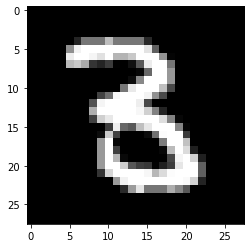

tensor(0)


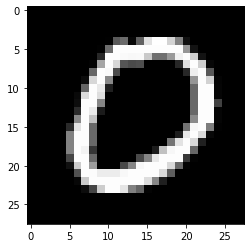

tensor(4)


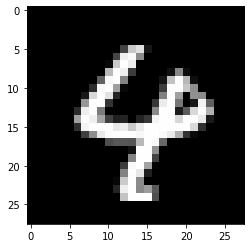

tensor(6)


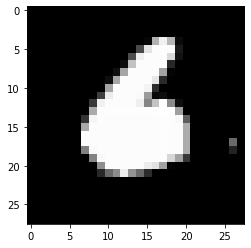

tensor(2)


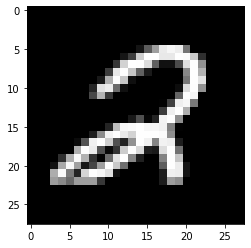

tensor(5)


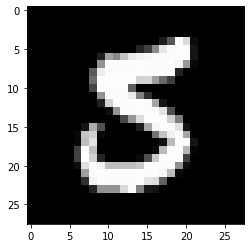

tensor(0)


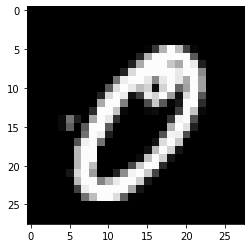

tensor(0)


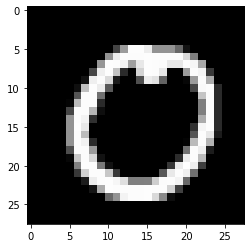

In [7]:
import matplotlib.pyplot as plt

for index, (images,labels) in enumerate(bal_train_loader):
    if index % 10 == 0:
        print(labels[1])
        plt.imshow(images[1].reshape(28,28), cmap="gray")
        plt.show()

## Creating imbalanced dataset

In [8]:
def make_imbalanced(ds_x, ds_y, imbalanced_weights=imbalanced_weights):
    class_partition = {k:[] for k in range(10)}

    for x, y in zip(ds_x, ds_y):
        class_partition[y].append((x, y))

    for i in range(10):
        idxs = np.random.randint(0, len(class_partition[i]), int(imbalanced_weights[i]*len(class_partition[i])))
        class_partition[i] = [class_partition[i][j] for j in idxs]
        print(f"class {i}: size={len(class_partition[i])}")

    imbalanced_train = []

    for partition in class_partition.values():
        imbalanced_train.extend(partition)

    np.random.shuffle(imbalanced_train)
    imbalanced_train_x, imbalanced_train_y = zip(*imbalanced_train)
    
    return imbalanced_train_x, imbalanced_train_y

imb_train_x, imb_train_y = make_imbalanced(train_x, train_y)

class 0: size=496
class 1: size=562
class 2: size=4942
class 3: size=5132
class 4: size=4894
class 5: size=450
class 6: size=4908
class 7: size=518
class 8: size=4891
class 9: size=4960


<AxesSubplot:ylabel='Count'>

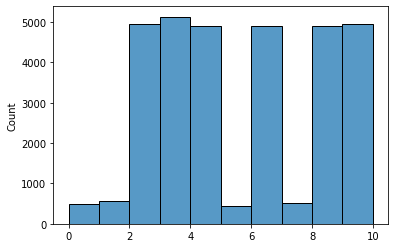

In [9]:
sns.histplot(imb_train_y, bins=[i for i in range(11)])

## create a dataset with symmetric noise

In [10]:
def apply_sym_noise(ds_x, ds_y, noise_ratio=0.3):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        if np.random.rand() <= noise_ratio:
            noisy_labels.append(np.random.randint(10))
        else:
            noisy_labels.append(y)

    return ds_x, np.array(noisy_labels)

x, y = apply_sym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

## create a dataset with asymmetric noise

In [11]:
def apply_asym_noise(ds_x, ds_y, asym_noise_map=asymmetric_noise, noise_ratio=0.3):
    noisy_labels = []
    for x, y in zip(ds_x, ds_y):
        if np.random.rand() <= noise_ratio:
            noisy_labels.append(asym_noise_map[y])
        else:
            noisy_labels.append(y)

    return ds_x, np.array(noisy_labels)

x, y = apply_asym_noise(test_x, test_y)
x.shape, y.shape

((10000, 1, 28, 28), (10000,))

# Generating All datasets

In [12]:
from torch.utils.data import TensorDataset

def generate_data_loader_from_np(_x, _y, batch_size_train=batch_size_train, valid_frac=0.1):
    tensor_x, tensor_y = torch.Tensor(np.array(_x)), torch.Tensor(np.array(_y)).long()
    train_set = TensorDataset(tensor_x, tensor_y)
    
    valid_size = int(len(train_set)*valid_frac)
    train_size = len(train_set) - valid_size
    
    train_set, val_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size_train,
        shuffle=True
    )

    valid_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size_train,
        shuffle=True,
    )
    
    return train_loader, valid_loader


imb_train_loader, imb_valid_loader = generate_data_loader_from_np(imb_train_x, imb_train_y)


In [53]:
#balanced: train_x, train_y
#imbalanced: imb_train_x, imb_train_y
bal_sym_train_x, bal_sym_train_y = apply_sym_noise(train_x, train_y)
bal_asym_train_x, bal_asym_train_y = apply_asym_noise(train_x, train_y)
imb_sym_train_x, imb_sym_train_y = apply_sym_noise(imb_train_x, imb_train_y)
imb_asym_train_x, imb_asym_train_y = apply_asym_noise(imb_train_x, imb_train_y)

#balanced: train_loader
#imbalanced: imb_train_loader
bal_sym_train_loader, bal_sym_valid_loader = generate_data_loader_from_np(bal_sym_train_x, bal_sym_train_y)
bal_asym_train_loader, bal_asym_valid_loader = generate_data_loader_from_np(bal_asym_train_x, bal_asym_train_y)
imb_sym_train_loader, imb_sym_valid_loader = generate_data_loader_from_np(imb_sym_train_x, imb_sym_train_y)
imb_asym_train_loader, imb_asym_valid_loader = generate_data_loader_from_np(imb_asym_train_x, imb_asym_train_y)

<AxesSubplot:ylabel='Count'>

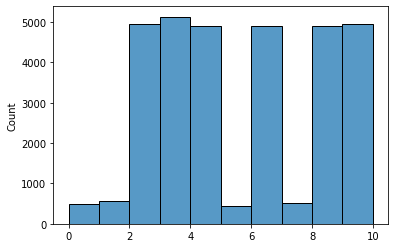

In [14]:
sns.histplot(imb_train_y, bins=[i for i in range(11)])


# Models

## validation functions

### draw confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True)



In [16]:
from sklearn.metrics import classification_report

def clf_metrics(y_true, y_pred, n_class=10):
    class_names = [str(i) for i in range(n_class)]
    print(classification_report(y_true, y_pred, digits=4))
    


## Logistic Regression

### preprocessing data

In [17]:
def preprocess(x, y):
    x, y = np.array(x).squeeze(), np.array(y)
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

(50000, 784)

### model definition

In [42]:
lr = LogisticRegression(
    
    multi_class='ovr',
    random_state=random_seed,
    verbose=True,
) 

lr.fit(train_x, train_y)
y_pred = svm.predict(test_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  3.56581D+04

At iterate   50    f=  1.03141D+03    |proj g|=  3.17595D+01

At iterate  100    f=  9.83512D+02    |proj g|=  8.01004D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    110      1     0     0   8.010D+00   9.835D+02
  F =   983.51238125045086     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  1.09469D+03    |proj g|=  1.59415D+01

At iterate  100    f=  1.03614D+03    |proj g|=  8.93726D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    114      1     0     0   8.937D+00   1.036D+03
  F =   1036.1418203003143     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.73508D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  3.19682D+03    |proj g|=  3.77829D+01


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  3.10326D+03    |proj g|=  1.50223D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    114      1     0     0   1.502D+01   3.103D+03
  F =   3103.2604674215559     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.90443D+04

At iterate   50    f=  3.86220D+03    |proj g|=  3.41590D+01


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate  100    f=  3.78445D+03    |proj g|=  4.24488D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    110      1     0     0   4.245D+01   3.784D+03
  F =   3784.4524199221578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  3.23933D+04

At iterate   50    f=  2.27201D+03    |proj g|=  7.22647D+01

At iterate  100    f=  2.17455D+03    |proj g|=  1.30612D+01

       

/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  4.09818D+03    |proj g|=  1.10329D+02

At iterate  100    f=  3.95811D+03    |proj g|=  1.71250D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    112      1     0     0   1.713D+01   3.958D+03
  F =   3958.1072358418560     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.94212D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  1.67260D+03    |proj g|=  2.64388D+01

At iterate  100    f=  1.62325D+03    |proj g|=  1.00284D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    116      1     0     0   1.003D+01   1.623D+03
  F =   1623.2460841622335     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  3.08107D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  2.13891D+03    |proj g|=  4.03928D+01

At iterate  100    f=  2.07884D+03    |proj g|=  1.89532D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    109      1     0     0   1.895D+01   2.079D+03
  F =   2078.8387577443223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.55138D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  5.63835D+03    |proj g|=  4.13856D+01

At iterate  100    f=  5.56927D+03    |proj g|=  2.87040D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    115      1     0     0   2.870D+01   5.569D+03
  F =   5569.2715350589388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          785     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46574D+04    |proj g|=  2.71090D+04


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.



At iterate   50    f=  4.71919D+03    |proj g|=  6.54175D+01

At iterate  100    f=  4.63855D+03    |proj g|=  5.22290D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  785    100    113      1     0     0   5.223D+01   4.639D+03
  F =   4638.5508410830344     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.5s finished


ValueError: X has 784 features, but SVC is expecting 10 features as input.

In [43]:
lr.coef_.shape

(10, 784)

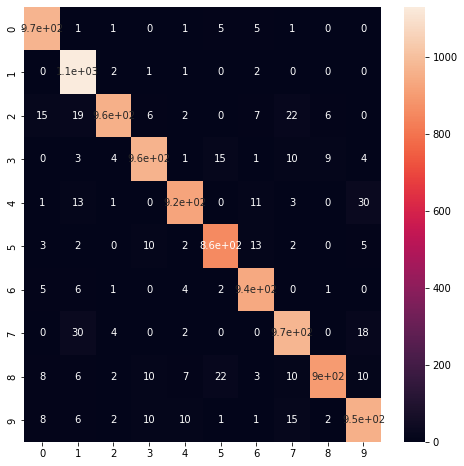

In [44]:
conf_mat(test_y, y_pred)

### model report

In [45]:
clf_metrics(test_y, y_pred)

              precision    recall  f1-score   support

           0     0.9602    0.9857    0.9728       980
           1     0.9292    0.9947    0.9609      1135
           2     0.9825    0.9254    0.9531      1032
           3     0.9630    0.9535    0.9582      1010
           4     0.9685    0.9399    0.9540       982
           5     0.9500    0.9585    0.9542       892
           6     0.9562    0.9802    0.9680       958
           7     0.9392    0.9475    0.9433      1028
           8     0.9803    0.9199    0.9492       974
           9     0.9344    0.9455    0.9399      1009

    accuracy                         0.9554     10000
   macro avg     0.9564    0.9551    0.9554     10000
weighted avg     0.9560    0.9554    0.9553     10000



### train on all datasets

In [20]:
import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    
    lr = LogisticRegression(
        multi_class='ovr',
        random_state=random_seed,
        verbose=False,
        n_jobs=-1
    )  

    lr.fit(_x, _y)
    with open(f'lr-{name}', 'wb') as f:
        pickle.dump(lr, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:05<00:00, 10.94s/it]


### load and test lr model

In [21]:
for model_name in ['lr-balanced', 'lr-imbalanced', 'lr-bal_sym',
                  'lr-bal_asym', 'lr-imb_sym', 'lr-imb_asym']:
    with open(model_name, 'rb') as f:
        lr = pickle.load(f)

    print(model_name)
    
    y_pred = lr.predict(test_x)
    clf_metrics(test_y, y_pred)

lr-balanced
              precision    recall  f1-score   support

           0     0.9458    0.9786    0.9619       980
           1     0.9512    0.9789    0.9648      1135
           2     0.9299    0.8866    0.9077      1032
           3     0.9016    0.9069    0.9042      1010
           4     0.9148    0.9297    0.9222       982
           5     0.8895    0.8576    0.8733       892
           6     0.9358    0.9436    0.9397       958
           7     0.9301    0.9193    0.9247      1028
           8     0.8717    0.8789    0.8753       974
           9     0.8976    0.8860    0.8918      1009

    accuracy                         0.9178     10000
   macro avg     0.9168    0.9166    0.9166     10000
weighted avg     0.9176    0.9178    0.9175     10000

lr-imbalanced
              precision    recall  f1-score   support

           0     0.9770    0.9092    0.9419       980
           1     0.9769    0.9295    0.9526      1135
           2     0.8835    0.8963    0.8899      103

## Embed-rf

### umap embeddings

In [32]:
import umap

def encode_dataset(_x, reducer=None):
    if reducer is None:
        reducer = umap.UMAP(n_components=5, n_jobs=-1)
        reducer.fit(_x)
    return reducer.transform(_x), reducer
    


### training on all datasets

In [33]:
%%time

import pickle
from sklearn.ensemble import RandomForestClassifier

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    
    _x, reducer = encode_dataset(_x)
    
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=random_seed,
        n_jobs=-1
    ) 

    rf.fit(_x, _y)
    
    with open(f'erf-{name}', 'wb') as f:
        pickle.dump(rf, f)
        
    with open(f'erf-{name}-encoder', 'wb') as f:
        pickle.dump(reducer, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:18<00:00, 23.14s/it]

CPU times: user 10min 51s, sys: 2min 36s, total: 13min 27s
Wall time: 2min 18s


### validate

In [34]:
for model_name in ['erf-balanced', 'erf-imbalanced', 'erf-bal_sym', 'erf-bal_asym', 'erf-imb_sym', 'erf-imb_asym']:
    with open(model_name, 'rb') as f:
        erf = pickle.load(f)

    with open(f"{model_name}-encoder", 'rb') as f:
        reducer = pickle.load(f)
        
    print(model_name)
    encode_x = encode_dataset(test_x, reducer)[0]
    y_pred = erf.predict(encode_x)
    clf_metrics(test_y, y_pred)

erf-balanced
              precision    recall  f1-score   support

           0     0.9556    0.9888    0.9719       980
           1     0.9270    0.9956    0.9601      1135
           2     0.9856    0.9293    0.9566      1032
           3     0.9602    0.9545    0.9573      1010
           4     0.9725    0.9379    0.9549       982
           5     0.9592    0.9496    0.9544       892
           6     0.9591    0.9802    0.9695       958
           7     0.9411    0.9475    0.9443      1028
           8     0.9793    0.9251    0.9514       974
           9     0.9337    0.9495    0.9415      1009

    accuracy                         0.9562     10000
   macro avg     0.9573    0.9558    0.9562     10000
weighted avg     0.9569    0.9562    0.9561     10000

erf-imbalanced
              precision    recall  f1-score   support

           0     0.9881    0.9286    0.9574       980
           1     0.9381    0.9877    0.9622      1135
           2     0.9690    0.9399    0.9543      1

### visualize embedding space

In [ ]:
with open(f"erf-balanced-encoder", 'rb') as f:
        reducer = pickle.load(f)
        
embedding = encode_dataset(test_x, reducer)[0]


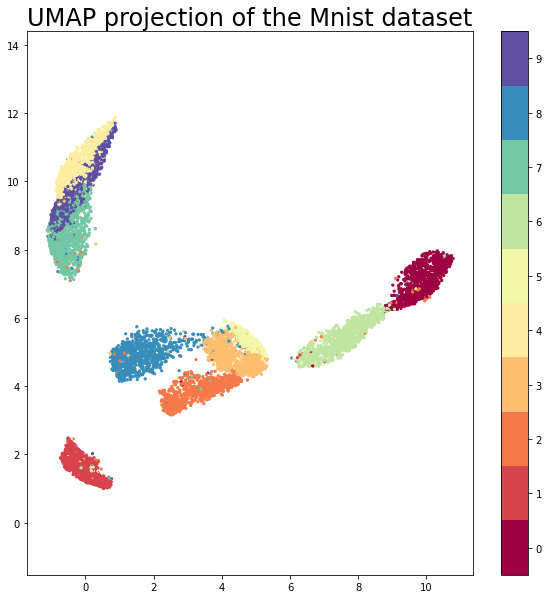

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=test_y, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Mnist dataset', fontsize=24);

In [50]:
from babyplots import Babyplot

bp = Babyplot(background_color="#ffffddff", turntable=True)
bp.add_plot(embedding[:,:3].tolist(), "pointCloud", "categories", test_y.tolist(), {
    "colorScale": "Dark2",
})
bp

<IPython.core.display.Javascript object>

In [52]:
bp.save_as_html('clusters.html')

## SVM

### preprocessing data

In [21]:
def preprocess(x, y):
    x, y = np.array(x).squeeze(), np.array(y)
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

(50000, 784)

### model definition

In [25]:
svm = SVC(
    kernel='rbf',
    decision_function_shape='ovr',
    random_state=random_seed,
    verbose=True,
) 

svm.fit(train_x, train_y)
y_pred = svm.predict(test_x)

[LibSVM]*
optimization finished, #iter = 591
obj = -0.214330, rho = 0.373004
nSV = 67, nBSV = 0
......................*..............*
optimization finished, #iter = 36848
obj = -9.892223, rho = 4.243326
nSV = 301, nBSV = 0
.......*......*
optimization finished, #iter = 13039
obj = -2.908381, rho = 2.822099
nSV = 219, nBSV = 0
..*..*
optimization finished, #iter = 4179
obj = -0.994940, rho = 1.074030
nSV = 165, nBSV = 0
...................................................*.................................*
optimization finished, #iter = 84723
obj = -31.133473, rho = 10.758067
nSV = 326, nBSV = 1
.........*......*
optimization finished, #iter = 15550
obj = -5.314474, rho = 0.553138
nSV = 233, nBSV = 0
..*.*
optimization finished, #iter = 3480
obj = -0.842590, rho = 1.093112
nSV = 148, nBSV = 0
.........................*..................*
optimization finished, #iter = 43702
obj = -13.929025, rho = 2.170399
nSV = 286, nBSV = 0
.....*...*
optimization finished, #iter = 8494
obj = -2.79410

KeyboardInterrupt: 

In [ ]:
svm.coef_.shape

In [ ]:
conf_mat(test_y, y_pred)

### model report

In [ ]:
clf_metrics(test_y, y_pred)

### train on all datasets

In [17]:
import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    svm = SVC(
        kernel='rbf',
        decision_function_shape='ovr',
        random_state=random_seed,
        verbose=True,
    ) 

    svm.fit(_x, _y)
    with open(f'svm-{name}', 'wb') as f:
        pickle.dump(svm, f)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

[LibSVM]*
optimization finished, #iter = 167
obj = -18.116523, rho = -0.650438
nSV = 74, nBSV = 8
*
optimization finished, #iter = 576
obj = -98.138818, rho = 0.588515
nSV = 300, nBSV = 80
*
optimization finished, #iter = 501
obj = -75.427290, rho = 0.430316
nSV = 265, nBSV = 57
*
optimization finished, #iter = 368
obj = -50.972630, rho = 0.053942
nSV = 189, nBSV = 40
*
optimization finished, #iter = 447
obj = -66.821007, rho = 0.079031
nSV = 223, nBSV = 47
*
optimization finished, #iter = 520
obj = -89.226850, rho = 0.307024
nSV = 263, nBSV = 74
*
optimization finished, #iter = 260
obj = -38.311150, rho = -0.125786
nSV = 137, nBSV = 29
*
optimization finished, #iter = 496
obj = -82.770045, rho = 0.362379
nSV = 266, nBSV = 67
*
optimization finished, #iter = 461
obj = -69.971749, rho = 0.112476
nSV = 228, nBSV = 57
*
optimization finished, #iter = 370
obj = -91.837285, rho = 1.374290
nSV = 216, nBSV = 102
*
optimization finished, #iter = 342
obj = -85.226937, rho = 1.349535
nSV = 207, 

 20%|█████████                                    | 1/5 [00:59<03:58, 59.51s/it]

*
optimization finished, #iter = 1590
obj = -299.484642, rho = -0.150557
nSV = 851, nBSV = 311
Total nSV = 7562
[LibSVM]....*.*
optimization finished, #iter = 5773
obj = -2562.035805, rho = 0.027085
nSV = 3612, nBSV = 2528
....*.*
optimization finished, #iter = 5644
obj = -2837.226897, rho = 0.087212
nSV = 3995, nBSV = 2806
....*..*
optimization finished, #iter = 6258
obj = -2803.413158, rho = 0.110960
nSV = 4017, nBSV = 2705
....*..*
optimization finished, #iter = 6216
obj = -2722.610071, rho = 0.051009
nSV = 3933, nBSV = 2632
....*..*
optimization finished, #iter = 6126
obj = -2802.862320, rho = 0.127683
nSV = 4030, nBSV = 2771
....*..*
optimization finished, #iter = 6198
obj = -2795.378994, rho = 0.175292
nSV = 3973, nBSV = 2757
....*..*
optimization finished, #iter = 6298
obj = -2686.320385, rho = 0.341358
nSV = 3865, nBSV = 2593
....*..*
optimization finished, #iter = 6426
obj = -2811.528237, rho = -0.534901
nSV = 4078, nBSV = 2718
....*.*
optimization finished, #iter = 5900
obj =

 40%|█████████████████▌                          | 2/5 [15:10<26:14, 524.92s/it]

[LibSVM]*
optimization finished, #iter = 632
obj = -114.740338, rho = 0.178754
nSV = 340, nBSV = 99
*.*
optimization finished, #iter = 1143
obj = -188.983936, rho = 0.395855
nSV = 557, nBSV = 168
*
optimization finished, #iter = 907
obj = -137.368683, rho = 0.093136
nSV = 444, nBSV = 110
*
optimization finished, #iter = 735
obj = -106.799678, rho = -0.169562
nSV = 357, nBSV = 82
.*
optimization finished, #iter = 1602
obj = -281.645343, rho = 0.690542
nSV = 760, nBSV = 258
*.*
optimization finished, #iter = 1464
obj = -288.295136, rho = 0.538565
nSV = 735, nBSV = 273
*.*
optimization finished, #iter = 1103
obj = -221.284480, rho = 0.858450
nSV = 587, nBSV = 212
*.*
optimization finished, #iter = 1300
obj = -222.723971, rho = 0.394051
nSV = 640, nBSV = 192
*
optimization finished, #iter = 839
obj = -154.087293, rho = -0.057963
nSV = 422, nBSV = 141
*.*
optimization finished, #iter = 1293
obj = -326.901900, rho = 0.200828
nSV = 718, nBSV = 348
*.*
optimization finished, #iter = 1288
obj =

 60%|█████████████████████████▊                 | 3/5 [51:48<42:58, 1289.24s/it]

[LibSVM].
*
optimization finished, #iter = 1839
obj = -1532.954330, rho = 0.253777
nSV = 1989, nBSV = 1671
..*.*
optimization finished, #iter = 3598
obj = -1706.508191, rho = 0.218528
nSV = 2566, nBSV = 1656
..*.*
optimization finished, #iter = 3456
obj = -1698.028555, rho = 0.409143
nSV = 2511, nBSV = 1664
..*.*
optimization finished, #iter = 3570
obj = -1629.527154, rho = 0.067079
nSV = 2403, nBSV = 1579
.
*.*
optimization finished, #iter = 2157
obj = -1619.463074, rho = 0.175846
nSV = 2141, nBSV = 1729
..*.*
optimization finished, #iter = 3163
obj = -1608.943090, rho = -0.111845
nSV = 2344, nBSV = 1620
.
*
optimization finished, #iter = 1965
obj = -1571.640346, rho = 0.347181
nSV = 2056, nBSV = 1696
..*.*
optimization finished, #iter = 3625
obj = -1673.527898, rho = -0.090798
nSV = 2489, nBSV = 1611
..*.*
optimization finished, #iter = 3997
obj = -1683.145672, rho = 0.163862
nSV = 2502, nBSV = 1600
..*.*
optimization finished, #iter = 3698
obj = -1764.330285, rho = 0.088444
nSV = 26

 80%|████████████████████████████████▊        | 4/5 [1:06:29<18:47, 1127.68s/it]

[LibSVM]*
optimization finished, #iter = 247
obj = -34.424215, rho = -0.141740
nSV = 120, nBSV = 26
*
optimization finished, #iter = 552
obj = -92.006599, rho = 0.545667
nSV = 299, nBSV = 77
*
optimization finished, #iter = 464
obj = -70.222059, rho = 0.342303
nSV = 252, nBSV = 55
*
optimization finished, #iter = 368
obj = -50.972630, rho = 0.053942
nSV = 189, nBSV = 40
*
optimization finished, #iter = 582
obj = -103.419723, rho = 0.617673
nSV = 298, nBSV = 92
*
optimization finished, #iter = 576
obj = -103.177481, rho = 0.557917
nSV = 291, nBSV = 80
*
optimization finished, #iter = 515
obj = -91.889135, rho = 0.748946
nSV = 283, nBSV = 77
*
optimization finished, #iter = 669
obj = -100.418944, rho = 0.702711
nSV = 321, nBSV = 73
*
optimization finished, #iter = 461
obj = -69.971749, rho = 0.112476
nSV = 228, nBSV = 57
*
optimization finished, #iter = 617
obj = -136.770916, rho = 0.543174
nSV = 343, nBSV = 140
*
optimization finished, #iter = 575
obj = -155.992379, rho = 0.569733
nSV =

100%|██████████████████████████████████████████| 5/5 [1:11:23<00:00, 856.62s/it]

*
optimization finished, #iter = 1839
obj = -395.219955, rho = -0.780101
nSV = 1022, nBSV = 414
Total nSV = 16898


### load and test svm models

In [21]:
for model_name in ['svm-balanced', 'svm-imbalanced', 'svm-bal_sym',
                  'svm-bal_asym', 'svm-imb_sym', 'svm-imb_asym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)

    print(model_name)
    
    y_pred = svm.predict(test_x)
    clf_metrics(test_y, y_pred)

svm-balanced
              precision    recall  f1-score   support

           0     0.9808    0.9918    0.9863       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9729    0.9748    0.9739      1032
           3     0.9764    0.9832    0.9798      1010
           4     0.9796    0.9776    0.9786       982
           5     0.9853    0.9787    0.9820       892
           6     0.9843    0.9833    0.9838       958
           7     0.9745    0.9669    0.9707      1028
           8     0.9714    0.9774    0.9744       974
           9     0.9739    0.9613    0.9676      1009

    accuracy                         0.9788     10000
   macro avg     0.9788    0.9787    0.9787     10000
weighted avg     0.9788    0.9788    0.9788     10000

svm-imbalanced
              precision    recall  f1-score   support

           0     0.9916    0.9684    0.9799       980
           1     0.9902    0.9789    0.9845      1135
           2     0.9406    0.9826    0.9611      1

FileNotFoundError: [Errno 2] No such file or directory: 'svm-imb_asm'

In [38]:
for model_name in ['svm-bal_sym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)

    print(model_name)
    
    y_pred = svm.predict(test_x)
    clf_metrics(test_y, y_pred)

svm-bal_sym
              precision    recall  f1-score   support

           0     0.9749    0.9918    0.9833       980
           1     0.9869    0.9921    0.9895      1135
           2     0.9785    0.9719    0.9752      1032
           3     0.9773    0.9782    0.9777      1010
           4     0.9727    0.9796    0.9762       982
           5     0.9798    0.9798    0.9798       892
           6     0.9833    0.9854    0.9844       958
           7     0.9782    0.9621    0.9701      1028
           8     0.9664    0.9754    0.9709       974
           9     0.9707    0.9534    0.9620      1009

    accuracy                         0.9770     10000
   macro avg     0.9769    0.9770    0.9769     10000
weighted avg     0.9770    0.9770    0.9770     10000



## RF

### preprocessing data

In [18]:
def preprocess(x, y):
    x, y = np.array(x).squeeze(), np.array(y)
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

(50000, 784)

### train on all datasets

In [29]:
import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=random_seed,
        n_jobs=-1
    ) 

    rf.fit(_x, _y)
    with open(f'rf-{name}', 'wb') as f:
        pickle.dump(rf, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.44s/it]


### load and test svm models

In [30]:
for model_name in ['rf-balanced', 'rf-imbalanced', 'rf-bal_sym',
                  'rf-bal_asym', 'rf-imb_sym', 'rf-imb_asym']:
    with open(model_name, 'rb') as f:
        rf = pickle.load(f)

    print(model_name)
    
    y_pred = rf.predict(test_x)
    clf_metrics(test_y, y_pred)

rf-balanced
              precision    recall  f1-score   support

           0     0.9660    0.9867    0.9763       980
           1     0.9765    0.9877    0.9820      1135
           2     0.9412    0.9467    0.9440      1032
           3     0.9459    0.9347    0.9402      1010
           4     0.9519    0.9267    0.9391       982
           5     0.9596    0.9327    0.9460       892
           6     0.9539    0.9729    0.9633       958
           7     0.9548    0.9251    0.9397      1028
           8     0.9384    0.9230    0.9306       974
           9     0.8888    0.9346    0.9111      1009

    accuracy                         0.9476     10000
   macro avg     0.9477    0.9471    0.9472     10000
weighted avg     0.9479    0.9476    0.9476     10000

rf-imbalanced
              precision    recall  f1-score   support

           0     0.9953    0.8653    0.9258       980
           1     0.9953    0.9383    0.9660      1135
           2     0.8560    0.9506    0.9008      103

## Embed-svm

### umap embeddings

In [18]:
import umap
from collections import Counter
from skimage.transform import rotate

def encode_dataset(_x, reducer=None):
    if reducer is None:
        reducer = umap.UMAP(random_state=random_seed, n_components=10)
        reducer.fit(_x)
    return reducer.transform(_x), reducer
    


def class_counter(_x, _y):
    c = Counter()
    for y in _y:
        c.update([int(y),])
    
    clist = [0]*10
    
    for cls, cnt in c.items():
        clist[cls] = cnt
        
    return clist


def augment_dataset(_x, _y):
    cls_cnt = class_counter(_x, _y)
    aug_x, aug_y = [], []
    
    for img_x, img_y in zip(_x, _y):
        n_augs = max(cls_cnt)//cls_cnt[img_y]
        aug_x.append(img_x)
        aug_y.append(img_y)
        for _ in range(n_augs-1):
            if np.random.rand()<0.5:
                rot_x = np.fliplr(img_x)
            else:
                rot_x = rotate(img_x, np.random.randint(-7, 7))
            aug_x.append(rot_x)
            aug_y.append(img_y)
    return np.array(aug_x), np.array(aug_y)
    
x, y = augment_dataset(imb_train_x, imb_train_y)
x.shape, y.shape

((49357, 1, 28, 28), (49357,))

<AxesSubplot:ylabel='Count'>

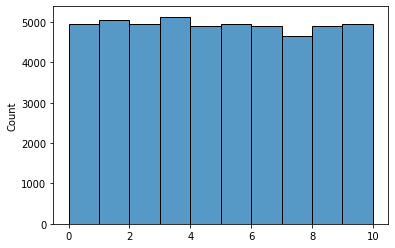

In [19]:
sns.histplot(y, bins=[i for i in range(11)])


### training augment-svm

In [23]:
%%time

import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x = np.array(_x).reshape(-1, 28, 28)
    _x, _y = augment_dataset(_x, _y)
    _x, _y = preprocess(_x, _y)
    
    
    svm = SVC(
        kernel='rbf',
        max_iter=500,
        decision_function_shape='ovr',
        random_state=random_seed,
        verbose=False,
    ) 

    svm.fit(_x, _y)
    
    with open(f'augsvm-{name}', 'wb') as f:
        pickle.dump(svm, f)


  0%|                                                                                                                             | 0/6 [00:00<?, ?it/s]/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 17%|███████████████████▎                                                                                                | 1/6 [02:01<10:07, 121.55s/it]/Users/navid/miniforge_x86_64/envs/pytorch_x86/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
 33%|██████████████████████████████████████▋                                                                             | 2/6 [03:30<06:50, 102.55s/it]/Users/navid/miniforge_x86_64/envs/pytorch_x

CPU times: user 14min 27s, sys: 4.12 s, total: 14min 31s
Wall time: 23min 26s


### validate

In [20]:
for model_name in ['augsvm-balanced', 'augsvm-imbalanced', 'augsvm-bal_sym', 'augsvm-bal_asym', 'augsvm-imb_sym', 'augsvm-imb_asym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)
    
    print(model_name)
    y_pred = svm.predict(test_x)
    clf_metrics(test_y, y_pred)

augsvm-balanced
              precision    recall  f1-score   support

           0     0.9808    0.9918    0.9863       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9729    0.9748    0.9739      1032
           3     0.9774    0.9832    0.9803      1010
           4     0.9785    0.9745    0.9765       982
           5     0.9842    0.9787    0.9815       892
           6     0.9843    0.9833    0.9838       958
           7     0.9736    0.9679    0.9707      1028
           8     0.9714    0.9774    0.9744       974
           9     0.9719    0.9594    0.9656      1009

    accuracy                         0.9784     10000
   macro avg     0.9784    0.9783    0.9783     10000
weighted avg     0.9784    0.9784    0.9784     10000

augsvm-imbalanced
              precision    recall  f1-score   support

           0     0.9876    0.9755    0.9815       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9557    0.9816    0.9685 

### training on all datasets

In [38]:
%%time

import pickle

datasets = [
    (train_x, train_y, 'balanced'),
    (imb_train_x, imb_train_y, 'imbalanced'),
    (bal_sym_train_x, bal_sym_train_y, 'bal_sym'),
    (bal_asym_train_x, bal_asym_train_y, 'bal_asym'),
    (imb_sym_train_x, imb_sym_train_y, 'imb_sym'),
    (imb_asym_train_x, imb_asym_train_y, 'imb_asym'),
]

for _x, _y, name in tqdm(datasets):
    _x, _y = preprocess(_x, _y)
    
    _x, reducer = encode_dataset(_x)
    
    svm = SVC(
        kernel='rbf',
        decision_function_shape='ovr',
        random_state=random_seed,
        verbose=False,
    ) 

    svm.fit(_x, _y)
    
    with open(f'esvm-{name}', 'wb') as f:
        pickle.dump(svm, f)
        
    with open(f'esvm-{name}-encoder', 'wb') as f:
        pickle.dump(reducer, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:52<00:00, 52.76s/it]

CPU times: user 1min 29s, sys: 51 s, total: 2min 20s
Wall time: 52.8 s


### validate

In [37]:
#for model_name in ['esvm-balanced', 'esvm-imbalanced', 'esvm-bal_sym', 'esvm-bal_asym', 'esvm-imb_sym', 'esvm-imb_asym']:
for model_name in ['esvm-bal_sym']:
    with open(model_name, 'rb') as f:
        svm = pickle.load(f)

    with open(f"{model_name}-encoder", 'rb') as f:
        reducer = pickle.load(f)
        
    print(model_name)
    encode_x = encode_dataset(test_x, reducer)[0]
    y_pred = svm.predict(encode_x)
    clf_metrics(test_y, y_pred)

esvm-bal_sym
              precision    recall  f1-score   support

           0     0.9612    0.9857    0.9733       980
           1     0.9285    0.9947    0.9604      1135
           2     0.9835    0.9264    0.9541      1032
           3     0.9630    0.9525    0.9577      1010
           4     0.9694    0.9348    0.9518       982
           5     0.9479    0.9585    0.9532       892
           6     0.9572    0.9812    0.9691       958
           7     0.9402    0.9484    0.9443      1028
           8     0.9803    0.9189    0.9486       974
           9     0.9299    0.9465    0.9381      1009

    accuracy                         0.9551     10000
   macro avg     0.9561    0.9548    0.9551     10000
weighted avg     0.9557    0.9551    0.9550     10000



## Logistic Regression on pytorch

### Model definition

In [ ]:
input_features = train_x[0].shape[1]
output_features = 10
num_epochs = 1

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, n_input_features, output_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_input_features, output_features)

    def forward(self, x):
        y_predicted = self.linear(x)
        return y_predicted


model = LogisticRegression(input_features * input_features, output_features)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


### Training the logistic regression model


In [ ]:
iter = 5

for epoch in range(num_epochs):
    for batch_number, (images, labels) in enumerate(train_loader):
        images = images.view(-1, input_features *
                             input_features).requires_grad_()
        labels = labels
         # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)
         # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        batch_number += 1

## Testing the logistic regression model

In [ ]:
predictions = []
real_classes = []

for images, labels in test_loader:
    # Load images to a Torch Variable
    images = images.view(-1, 28*28).requires_grad_()

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.tolist()
    labels = labels.tolist()
    predictions.append(predicted)
    real_classes.append(labels)

predictions = [item for sublist in predictions for item in sublist]
real_classes = [item for sublist in real_classes for item in sublist]

### Confusion matrix and predictions for Logistic regression

In [ ]:
conf_mat(real_classes,predictions)
clf_metrics(real_classes,predictions)

### Saving the model

In [ ]:
torch.save(model.state_dict(), 'models/logistic.pkl')

# LDAM

In [120]:
from collections import Counter


def class_counter(data_loader):
    c = Counter()
    for _, batch_label in data_loader:
        c.update([int(x) for x in batch_label.numpy()])
    
    clist = [0]*10
    
    for cls, cnt in c.items():
        clist[cls] = cnt
        
    return clist

cls_num_list = class_counter(train_loader)

## define components

In [122]:
from resnet import resnet20, resnet32, resnet56
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F


class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        #m_list = torch.tensor(m_list, dtype=torch.float)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        #index_float = torch.tensor(index, dtype=torch.float)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cls_num_list, device)
learning_rate = 1e-4
model = resnet56()
model.to(device)
criterion = LDAMLoss(cls_num_list)
criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                                momentum=0.9,
                                weight_decay=2e-4)

[1321, 1901, 3103, 3206, 4376, 2148, 3534, 2325, 5807, 4462] cuda


## training 

In [123]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")

def validate(model, criterion, valid_loader):
    
    losses = []
    preds = []
    y_true = []
    
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_true.extend(labels.cpu().numpy())
        predictions = model(images)
        preds.extend(predictions.cpu().numpy())
        
        loss = criterion(predictions, labels)
        losses.append(loss.detach().cpu().numpy())
        
    return np.array(preds), np.array(y_true), np.mean(losses)
        

def save_model(model, name):
    log(f"saving best model: {name}")
    torch.save(model.state_dict(), os.path.join('models', name))

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    epoch = epoch + 1
    if epoch <= 5:
        lr = lr * epoch / 5
    elif epoch > 180:
        lr = lr * 0.0001
    elif epoch > 160:
        lr = lr * 0.01
    else:
        lr = lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
def train_ldam(model, criterion, optimizer, train_loader, valid_loader, num_epochs, lr=0.1, verbose=1, model_prefix='balanced-ldam'):
    
    log(f"{datetime.now()}: training ldam on {model_prefix}")
    best_loss = np.inf
    
    for epoch in range(1, num_epochs+1):
        
        model.train()
        epoch_losses = []
        adjust_learning_rate(optimizer, epoch, lr)
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        log(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO: keep best model
            
            model.eval()
            with torch.no_grad():
                valid_preds, valid_labels, valid_loss = validate(model, criterion, valid_loader)
                train_preds, train_labels, train_loss = validate(model, criterion, train_loader)
                
                train_pred_labels = np.argmax(train_preds, axis=1)
                valid_pred_labels = np.argmax(valid_preds, axis=1)
                
                log(f"training loss: {train_loss}, train accuracy: {accuracy_score(train_labels, train_pred_labels)}")
                log(f"validation loss: {valid_loss}, validation accuracy: {accuracy_score(valid_labels, valid_pred_labels)}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                save_model(model, f"{model_prefix}-{epoch}")
                
        
# train_ldam(model, criterion, optimizer, train_loader, valid_loader, verbose=5, num_epochs=100)


## training on different datasets

In [ ]:
datasets = [
    (bal_train_loader, bal_valid_loader, 'balanced'),
    (imb_train_loader, imb_valid_loader, 'imbalanced'),
    (bal_sym_train_loader, bal_sym_valid_loader, 'bal_sym'),
    (bal_asym_train_loader, bal_asym_valid_loader, 'bal_asym'),
    (imb_sym_train_loader, imb_sym_valid_loader, 'imb_sym'),
    (imb_asym_train_loader, imb_asym_valid_loader, 'imb_asym'),
]

for train_loader, valid_loader, name in datasets:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cls_num_list = class_counter(train_loader)
    log(cls_num_list, device)
    learning_rate = 1e-4
    model = resnet32()
    model.to(device)
    criterion = LDAMLoss(cls_num_list)
    criterion.to(device)
#     optimizer = torch.optim.SGD(model.parameters(), learning_rate,
#                                 momentum=0.9,
#                                 weight_decay=2e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_ldam(model, criterion, optimizer, train_loader, valid_loader, verbose=5, num_epochs=100,
               model_prefix=f"ldam-{name}")
    

[4965, 5652, 4929, 5119, 4856, 4563, 4915, 5162, 4893, 4946]
2021-12-01 18:14:55.153492: training ldam on ldam-balanced


391it [00:15, 25.70it/s]


epoch 1, training loss: 14.616622924804688


391it [00:15, 26.05it/s]


epoch 2, training loss: 1.2673399448394775


391it [00:14, 26.10it/s]


epoch 3, training loss: 0.946378767490387


391it [00:14, 26.19it/s]


epoch 4, training loss: 0.87447190284729


391it [00:14, 26.39it/s]


epoch 5, training loss: 0.7637797594070435


100%|██████████| 391/391 [00:08<00:00, 44.65it/s]


training loss: 0.7710447311401367, train accuracy: 0.98194
validation loss: 0.8914386630058289, validation accuracy: 0.9792
saving best model: ldam-balanced-5


391it [00:15, 25.53it/s]


epoch 6, training loss: 0.6210240721702576


391it [00:15, 25.73it/s]


epoch 7, training loss: 0.6123214364051819


391it [00:15, 25.85it/s]


epoch 8, training loss: 0.5936293601989746


391it [00:14, 26.09it/s]


epoch 9, training loss: 0.509710431098938


391it [00:14, 26.07it/s]


epoch 10, training loss: 0.5679181814193726


100%|██████████| 391/391 [00:08<00:00, 44.38it/s]


training loss: 0.8026241660118103, train accuracy: 0.98114
validation loss: 1.0938472747802734, validation accuracy: 0.9751


391it [00:14, 26.36it/s]


epoch 11, training loss: 0.5745449066162109


391it [00:14, 26.54it/s]


epoch 12, training loss: 0.5278874635696411


391it [00:14, 26.18it/s]


epoch 13, training loss: 0.5106973052024841


391it [00:15, 25.80it/s]


epoch 14, training loss: 0.5929594039916992


391it [00:15, 25.72it/s]


epoch 15, training loss: 0.5087940692901611


 31%|███       | 120/391 [00:03<00:06, 42.02it/s]

## load best model and test

In [139]:
def load_model(path):
    model = resnet32()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


# model = load_model(os.path.join('models', 'balanced-70'))
# model

In [146]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

preds, y_true, loss = evaluate(test_loader, model)

## model report

In [147]:
def report(model_name):
    print("model:", model_name)
    model = load_model(os.path.join('models', model_name))
    preds, y_true, loss = evaluate(test_loader, model)
    clf_metrics(y_true, preds)

In [148]:
report('ldam-balanced-25')
report('ldam-imbalanced-75')
report('ldam-imb_sym-25')
report('ldam-imb_asym-40')
report('ldam-bal_sym-40')
report('ldam-bal_asym-20')

model: ldam-balanced-25
              precision    recall  f1-score   support

           0     0.9949    0.9959    0.9954       980
           1     0.9878    0.9991    0.9934      1135
           2     0.9932    0.9913    0.9922      1032
           3     0.9881    0.9871    0.9876      1010
           4     0.9899    0.9959    0.9929       982
           5     0.9610    0.9933    0.9768       892
           6     0.9979    0.9802    0.9889       958
           7     0.9931    0.9854    0.9893      1028
           8     0.9948    0.9805    0.9876       974
           9     0.9920    0.9841    0.9881      1009

    accuracy                         0.9894     10000
   macro avg     0.9893    0.9893    0.9892     10000
weighted avg     0.9895    0.9894    0.9894     10000

model: ldam-imbalanced-75
              precision    recall  f1-score   support

           0     0.9858    0.9939    0.9898       980
           1     0.9869    0.9956    0.9912      1135
           2     0.9809    0

# SCE

## defining components

In [150]:
import torch.nn as nn
import torch.nn.functional as F


class ConvBrunch(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super(ConvBrunch, self).__init__()
        padding = (kernel_size - 1) // 2
        self.out_conv = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_planes),
            nn.ReLU())

    def forward(self, x):
        return self.out_conv(x)


class SCEModel(nn.Module):
    def __init__(self):
        super(SCEModel, self).__init__()
        self.block1 = nn.Sequential(
            ConvBrunch(1, 64, 3),
            ConvBrunch(64, 64, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2 = nn.Sequential(
            ConvBrunch(64, 128, 3),
            ConvBrunch(128, 128, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.block3 = nn.Sequential(
            ConvBrunch(128, 196, 3),
            ConvBrunch(196, 196, 3),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(
            nn.Linear(1764, 256),
            nn.BatchNorm1d(256),
            nn.ReLU())
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        # x = self.global_avg_pool(x)
        x = x.view(-1, 1764)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


## defining loss function

In [151]:
class SCELoss(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels):
        # CCE
        ce = self.cross_entropy(pred, labels)

        # RCE
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

        # Loss
        loss = self.alpha * ce + self.beta * rce.mean()
        return loss
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-4
sce_model = SCEModel()
sce_model.to(device)
sce_criterion = SCELoss(alpha=0.1, beta=1.0)
sce_criterion.to(device)
sce_optimizer = torch.optim.Adam(sce_model.parameters(), lr=learning_rate)

## training 

In [152]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import os

def log(_str, path='./log.txt'):
    print(_str)
    with open(path, 'a') as f:
        f.write(f"{_str}\n")

def validate(model, criterion, valid_loader):
    
    losses = []
    preds = []
    y_true = []
    
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        y_true.extend(labels.cpu().numpy())
        predictions = model(images)
        preds.extend(predictions.cpu().numpy())
        
        loss = criterion(predictions, labels)
        losses.append(loss.detach().cpu().numpy())
        
    return np.array(preds), np.array(y_true), np.mean(losses)
        

def save_model(model, name):
    log(f"saving best model: {name}")
    torch.save(model.state_dict(), os.path.join('models', name))

        
def train_sce(model, criterion, optimizer, train_loader, valid_loader, num_epochs, verbose=1, model_prefix='balanced_sce'):
    
    log(f"{datetime.now()}: training sce on {model_prefix}")
    best_loss = np.inf
    
    for epoch in range(1, num_epochs+1):
        
        model.train()
        epoch_losses = []
        
        for batch_number, (images, labels) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.detach().cpu().numpy())

        log(f"epoch {epoch}, training loss: {np.mean(epoch_losses)}")
        
        if verbose and epoch % verbose == 0:
            #TODO: keep best model
            
            model.eval()
            with torch.no_grad():
                valid_preds, valid_labels, valid_loss = validate(model, criterion, valid_loader)
                train_preds, train_labels, train_loss = validate(model, criterion, train_loader)
                
                train_pred_labels = np.argmax(train_preds, axis=1)
                valid_pred_labels = np.argmax(valid_preds, axis=1)
                
                log(f"training loss: {train_loss}, train accuracy: {accuracy_score(train_labels, train_pred_labels)}")
                log(f"validation loss: {valid_loss}, validation accuracy: {accuracy_score(valid_labels, valid_pred_labels)}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                save_model(model, f"{model_prefix}-{epoch}")
                
        
#train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=100)


## train on all datasets

In [153]:
datasets = [
    (train_loader, valid_loader, 'balanced'),
    (imb_train_loader, imb_valid_loader, 'imbalanced'),
    (bal_sym_train_loader, bal_sym_valid_loader, 'bal_sym'),
    (bal_asym_train_loader, bal_asym_valid_loader, 'bal_asym'),
    (imb_sym_train_loader, imb_sym_valid_loader, 'imb_sym'),
    (imb_asym_train_loader, imb_asym_valid_loader, 'imb_asym'),
]

for train_loader, valid_loader, name in datasets:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4
    sce_model = SCEModel()
    sce_model.to(device)
    sce_criterion = SCELoss(alpha=0.1, beta=1.0)
    sce_criterion.to(device)
    sce_optimizer = torch.optim.Adam(sce_model.parameters(), lr=learning_rate)
    train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=50,
               model_prefix=f"sce-{name}")
    

2021-12-01 20:03:28.388296: training sce on sce-balanced


252it [00:01, 138.34it/s]


epoch 1, training loss: 2.599191427230835


252it [00:01, 144.58it/s]


epoch 2, training loss: 1.6694096326828003


252it [00:01, 143.74it/s]


epoch 3, training loss: 1.5596392154693604


252it [00:01, 142.93it/s]


epoch 4, training loss: 1.5164207220077515


252it [00:01, 143.08it/s]


epoch 5, training loss: 1.492029070854187


100%|██████████| 252/252 [00:00<00:00, 391.71it/s]


training loss: 1.4515239000320435, train accuracy: 0.8543019606624616
validation loss: 1.566757082939148, validation accuracy: 0.8455944055944056
saving best model: sce-balanced-5


252it [00:01, 141.91it/s]


epoch 6, training loss: 1.469722032546997


252it [00:01, 144.31it/s]


epoch 7, training loss: 1.4514431953430176


252it [00:01, 144.73it/s]


epoch 8, training loss: 1.4389547109603882


252it [00:01, 145.12it/s]


epoch 9, training loss: 1.4182199239730835


252it [00:01, 144.75it/s]


epoch 10, training loss: 1.3937002420425415


100%|██████████| 252/252 [00:00<00:00, 394.30it/s]


training loss: 1.323649287223816, train accuracy: 0.8673834011745332
validation loss: 1.601933479309082, validation accuracy: 0.8413986013986015


252it [00:01, 144.74it/s]


epoch 11, training loss: 1.3690084218978882


252it [00:01, 144.75it/s]


epoch 12, training loss: 1.3526145219802856


252it [00:01, 142.91it/s]


epoch 13, training loss: 1.2989858388900757


252it [00:01, 143.06it/s]


epoch 14, training loss: 1.274948000907898


252it [00:01, 144.55it/s]


epoch 15, training loss: 1.2240861654281616


100%|██████████| 252/252 [00:00<00:00, 392.32it/s]


training loss: 1.154787540435791, train accuracy: 0.885902495106112
validation loss: 1.7039024829864502, validation accuracy: 0.8318881118881118


252it [00:01, 144.11it/s]


epoch 16, training loss: 1.194599986076355


252it [00:01, 145.18it/s]


epoch 17, training loss: 1.136456847190857


252it [00:01, 145.53it/s]


epoch 18, training loss: 1.0949432849884033


252it [00:01, 144.11it/s]


epoch 19, training loss: 1.0605621337890625


252it [00:01, 144.78it/s]


epoch 20, training loss: 1.0138782262802124


100%|██████████| 252/252 [00:00<00:00, 394.81it/s]


training loss: 0.9786625504493713, train accuracy: 0.9035204921853153
validation loss: 1.7904903888702393, validation accuracy: 0.8229370629370629


252it [00:01, 143.81it/s]


epoch 21, training loss: 0.9738964438438416


252it [00:01, 142.64it/s]


epoch 22, training loss: 0.9565818309783936


252it [00:01, 143.66it/s]


epoch 23, training loss: 0.9202053546905518


252it [00:01, 144.49it/s]


epoch 24, training loss: 0.890706479549408


252it [00:01, 145.10it/s]


epoch 25, training loss: 0.8644614219665527


100%|██████████| 252/252 [00:00<00:00, 395.68it/s]


training loss: 0.8213667869567871, train accuracy: 0.9198645247490911
validation loss: 1.9188997745513916, validation accuracy: 0.8072727272727273


252it [00:01, 145.45it/s]


epoch 26, training loss: 0.8474301099777222


252it [00:01, 144.70it/s]


epoch 27, training loss: 0.8140764832496643


252it [00:01, 144.66it/s]


epoch 28, training loss: 0.8017933964729309


252it [00:01, 144.54it/s]


epoch 29, training loss: 0.7891044616699219


252it [00:01, 144.75it/s]


epoch 30, training loss: 0.7787726521492004


100%|██████████| 252/252 [00:00<00:00, 394.19it/s]


training loss: 0.7483455538749695, train accuracy: 0.9266382872945343
validation loss: 1.8782281875610352, validation accuracy: 0.8142657342657342


252it [00:01, 144.76it/s]


epoch 31, training loss: 0.7801088690757751


252it [00:01, 143.65it/s]


epoch 32, training loss: 0.744125485420227


252it [00:01, 142.75it/s]


epoch 33, training loss: 0.7443339824676514


252it [00:01, 143.48it/s]


epoch 34, training loss: 0.7371432781219482


252it [00:01, 144.10it/s]


epoch 35, training loss: 0.7240602374076843


100%|██████████| 252/252 [00:00<00:00, 396.20it/s]


training loss: 0.6929728388786316, train accuracy: 0.9316720007457353
validation loss: 1.9440125226974487, validation accuracy: 0.8050349650349651


252it [00:01, 143.24it/s]


epoch 36, training loss: 0.7281762957572937


252it [00:01, 143.55it/s]


epoch 37, training loss: 0.7124495506286621


252it [00:01, 143.49it/s]


epoch 38, training loss: 0.7142507433891296


252it [00:01, 143.56it/s]


epoch 39, training loss: 0.70233154296875


252it [00:01, 143.61it/s]


epoch 40, training loss: 0.6931256651878357


100%|██████████| 252/252 [00:00<00:00, 395.14it/s]


training loss: 0.6724796891212463, train accuracy: 0.9340334959450641
validation loss: 1.9931808710098267, validation accuracy: 0.8005594405594405


252it [00:01, 143.41it/s]


epoch 41, training loss: 0.7017030119895935


252it [00:01, 142.96it/s]


epoch 42, training loss: 0.6963695883750916


252it [00:01, 143.19it/s]


epoch 43, training loss: 0.6787360310554504


252it [00:01, 143.01it/s]


epoch 44, training loss: 0.6647684574127197


252it [00:01, 141.91it/s]


epoch 45, training loss: 0.6620309352874756


100%|██████████| 252/252 [00:00<00:00, 390.52it/s]


training loss: 0.6288304924964905, train accuracy: 0.9376378833545661
validation loss: 1.9455581903457642, validation accuracy: 0.8078321678321678


252it [00:01, 144.86it/s]


epoch 46, training loss: 0.6573938131332397


252it [00:01, 142.68it/s]


epoch 47, training loss: 0.6608955264091492


252it [00:01, 145.18it/s]


epoch 48, training loss: 0.6547207236289978


252it [00:01, 144.74it/s]


epoch 49, training loss: 0.6754165291786194


252it [00:01, 144.23it/s]


epoch 50, training loss: 0.659497082233429


100%|██████████| 252/252 [00:00<00:00, 388.63it/s]


training loss: 0.6183696985244751, train accuracy: 0.9386943417332132
validation loss: 1.987844467163086, validation accuracy: 0.8005594405594405
2021-12-01 20:05:03.667642: training sce on sce-imbalanced


252it [00:01, 143.77it/s]


epoch 1, training loss: 1.3523362874984741


252it [00:01, 144.60it/s]


epoch 2, training loss: 0.2245642989873886


252it [00:01, 144.42it/s]


epoch 3, training loss: 0.09992065280675888


252it [00:01, 144.43it/s]


epoch 4, training loss: 0.0536452941596508


252it [00:01, 144.54it/s]


epoch 5, training loss: 0.031705837696790695


100%|██████████| 252/252 [00:00<00:00, 391.51it/s]


training loss: 0.036434613168239594, train accuracy: 0.9993474815896591
validation loss: 0.09310044348239899, validation accuracy: 0.9944055944055944
saving best model: sce-imbalanced-5


252it [00:01, 144.18it/s]


epoch 6, training loss: 0.020460575819015503


252it [00:01, 144.59it/s]


epoch 7, training loss: 0.014897556975483894


252it [00:01, 144.44it/s]


epoch 8, training loss: 0.011412488296627998


252it [00:01, 144.70it/s]


epoch 9, training loss: 0.006342834793031216


252it [00:01, 144.54it/s]


epoch 10, training loss: 0.007830242626369


100%|██████████| 252/252 [00:00<00:00, 391.40it/s]


training loss: 0.0031419883016496897, train accuracy: 0.9999689276947457
validation loss: 0.043918389827013016, validation accuracy: 0.9960839160839161
saving best model: sce-imbalanced-10


252it [00:01, 144.37it/s]


epoch 11, training loss: 0.004901878070086241


252it [00:01, 144.54it/s]


epoch 12, training loss: 0.002799335401505232


252it [00:01, 142.88it/s]


epoch 13, training loss: 0.0019813901744782925


252it [00:01, 143.71it/s]


epoch 14, training loss: 0.001537836971692741


252it [00:01, 143.90it/s]


epoch 15, training loss: 0.0013090826105326414


100%|██████████| 252/252 [00:00<00:00, 393.78it/s]


training loss: 0.0008308737305924296, train accuracy: 1.0
validation loss: 0.03919708728790283, validation accuracy: 0.9963636363636363
saving best model: sce-imbalanced-15


252it [00:01, 143.07it/s]


epoch 16, training loss: 0.0011189176002517343


252it [00:01, 144.61it/s]


epoch 17, training loss: 0.0009340419201180339


252it [00:01, 144.67it/s]


epoch 18, training loss: 0.0008175820112228394


252it [00:01, 144.67it/s]


epoch 19, training loss: 0.0007099647191353142


252it [00:01, 144.80it/s]


epoch 20, training loss: 0.0006064045592211187


100%|██████████| 252/252 [00:00<00:00, 394.09it/s]


training loss: 0.0003966973163187504, train accuracy: 1.0
validation loss: 0.03656191751360893, validation accuracy: 0.9966433566433567
saving best model: sce-imbalanced-20


252it [00:01, 144.49it/s]


epoch 21, training loss: 0.0005313240690156817


252it [00:01, 144.30it/s]


epoch 22, training loss: 0.0004565495764836669


252it [00:01, 144.65it/s]


epoch 23, training loss: 0.00039840818499214947


252it [00:01, 144.61it/s]


epoch 24, training loss: 0.0003493003314360976


252it [00:01, 145.07it/s]


epoch 25, training loss: 0.00029768224339932203


100%|██████████| 252/252 [00:00<00:00, 394.97it/s]


training loss: 0.00018324467237107456, train accuracy: 1.0
validation loss: 0.037491269409656525, validation accuracy: 0.9960839160839161


252it [00:01, 144.86it/s]


epoch 26, training loss: 0.0002717704919632524


252it [00:01, 145.28it/s]


epoch 27, training loss: 0.0002291560231242329


252it [00:01, 145.10it/s]


epoch 28, training loss: 0.00019970974244643003


252it [00:01, 143.71it/s]


epoch 29, training loss: 0.00017581925203558058


252it [00:01, 142.39it/s]


epoch 30, training loss: 0.00015355480718426406


100%|██████████| 252/252 [00:00<00:00, 387.28it/s]


training loss: 9.096358553506434e-05, train accuracy: 1.0
validation loss: 0.03538553789258003, validation accuracy: 0.9969230769230769
saving best model: sce-imbalanced-30


252it [00:01, 141.44it/s]


epoch 31, training loss: 0.00013246665184851736


252it [00:01, 139.86it/s]


epoch 32, training loss: 0.00012457669072318822


252it [00:01, 143.94it/s]


epoch 33, training loss: 0.00010177261719945818


252it [00:01, 143.95it/s]


epoch 34, training loss: 9.240467625204474e-05


252it [00:01, 144.44it/s]


epoch 35, training loss: 8.234169945353642e-05


100%|██████████| 252/252 [00:00<00:00, 392.55it/s]


training loss: 4.652336792787537e-05, train accuracy: 1.0
validation loss: 0.03460529446601868, validation accuracy: 0.9963636363636363
saving best model: sce-imbalanced-35


252it [00:01, 144.11it/s]


epoch 36, training loss: 7.226355955936015e-05


252it [00:01, 144.22it/s]


epoch 37, training loss: 6.219714123290032e-05


252it [00:01, 144.30it/s]


epoch 38, training loss: 5.3188836318440735e-05


252it [00:01, 144.37it/s]


epoch 39, training loss: 4.732265369966626e-05


252it [00:01, 144.30it/s]


epoch 40, training loss: 4.3400887079769745e-05


100%|██████████| 252/252 [00:00<00:00, 393.53it/s]


training loss: 2.2363232346833684e-05, train accuracy: 1.0
validation loss: 0.03441556915640831, validation accuracy: 0.9966433566433567
saving best model: sce-imbalanced-40


252it [00:01, 143.92it/s]


epoch 41, training loss: 3.751099939108826e-05


252it [00:01, 144.38it/s]


epoch 42, training loss: 3.2718995498726144e-05


252it [00:01, 144.57it/s]


epoch 43, training loss: 2.9682396416319534e-05


252it [00:01, 144.71it/s]


epoch 44, training loss: 2.6724648705567233e-05


252it [00:01, 144.36it/s]


epoch 45, training loss: 2.3021138986223377e-05


100%|██████████| 252/252 [00:00<00:00, 397.01it/s]


training loss: 1.373559280182235e-05, train accuracy: 1.0
validation loss: 0.03473765775561333, validation accuracy: 0.9963636363636363


252it [00:01, 145.20it/s]


epoch 46, training loss: 2.1358178855734877e-05


252it [00:01, 145.23it/s]


epoch 47, training loss: 1.880351010186132e-05


252it [00:01, 143.88it/s]


epoch 48, training loss: 1.7791358914109878e-05


252it [00:01, 145.06it/s]


epoch 49, training loss: 1.6493011571583338e-05


252it [00:01, 144.36it/s]


epoch 50, training loss: 1.5216724932543002e-05


100%|██████████| 252/252 [00:00<00:00, 391.79it/s]


training loss: 9.846755347098224e-06, train accuracy: 1.0
validation loss: 0.03276411071419716, validation accuracy: 0.9969230769230769
saving best model: sce-imbalanced-50
2021-12-01 20:06:38.979668: training sce on sce-bal_sym


352it [00:02, 141.23it/s]


epoch 1, training loss: 3.433791399002075


352it [00:02, 139.22it/s]


epoch 2, training loss: 2.844289541244507


352it [00:02, 139.33it/s]


epoch 3, training loss: 2.7883245944976807


352it [00:02, 141.83it/s]


epoch 4, training loss: 2.7603392601013184


352it [00:02, 142.00it/s]


epoch 5, training loss: 2.742704391479492


100%|██████████| 352/352 [00:00<00:00, 385.29it/s]


training loss: 2.7360758781433105, train accuracy: 0.7317111111111111
validation loss: 2.810300350189209, validation accuracy: 0.7246
saving best model: sce-bal_sym-5


352it [00:02, 142.08it/s]


epoch 6, training loss: 2.7308313846588135


352it [00:02, 142.78it/s]


epoch 7, training loss: 2.717109441757202


352it [00:02, 142.30it/s]


epoch 8, training loss: 2.7042367458343506


352it [00:02, 141.53it/s]


epoch 9, training loss: 2.700453281402588


352it [00:02, 140.78it/s]


epoch 10, training loss: 2.687300205230713


100%|██████████| 352/352 [00:00<00:00, 382.95it/s]


training loss: 2.6710827350616455, train accuracy: 0.7361777777777778
validation loss: 2.8484904766082764, validation accuracy: 0.723


352it [00:02, 140.63it/s]


epoch 11, training loss: 2.67288875579834


352it [00:02, 142.78it/s]


epoch 12, training loss: 2.6624343395233154


352it [00:02, 144.20it/s]


epoch 13, training loss: 2.645092725753784


352it [00:02, 143.78it/s]


epoch 14, training loss: 2.6230695247650146


352it [00:02, 144.09it/s]


epoch 15, training loss: 2.6068801879882812


100%|██████████| 352/352 [00:00<00:00, 391.19it/s]


training loss: 2.554755449295044, train accuracy: 0.7462444444444445
validation loss: 2.933990478515625, validation accuracy: 0.7214


352it [00:02, 145.36it/s]


epoch 16, training loss: 2.579657554626465


352it [00:02, 144.89it/s]


epoch 17, training loss: 2.549380302429199


352it [00:02, 145.09it/s]


epoch 18, training loss: 2.514650583267212


352it [00:02, 142.88it/s]


epoch 19, training loss: 2.478769540786743


352it [00:02, 141.52it/s]


epoch 20, training loss: 2.429767608642578


100%|██████████| 352/352 [00:00<00:00, 381.27it/s]


training loss: 2.3654940128326416, train accuracy: 0.7667333333333334
validation loss: 3.0243072509765625, validation accuracy: 0.7114


352it [00:02, 141.95it/s]


epoch 21, training loss: 2.383129358291626


352it [00:02, 142.71it/s]


epoch 22, training loss: 2.326514959335327


352it [00:02, 142.47it/s]


epoch 23, training loss: 2.2642836570739746


352it [00:02, 142.53it/s]


epoch 24, training loss: 2.200373649597168


352it [00:02, 143.92it/s]


epoch 25, training loss: 2.1388847827911377


100%|██████████| 352/352 [00:00<00:00, 394.09it/s]


training loss: 2.0515947341918945, train accuracy: 0.8008666666666666
validation loss: 3.313129425048828, validation accuracy: 0.6892


352it [00:02, 143.19it/s]


epoch 26, training loss: 2.0626180171966553


352it [00:02, 141.47it/s]


epoch 27, training loss: 1.9912610054016113


352it [00:02, 142.49it/s]


epoch 28, training loss: 1.9175711870193481


352it [00:02, 143.69it/s]


epoch 29, training loss: 1.8392555713653564


352it [00:02, 143.64it/s]


epoch 30, training loss: 1.768825888633728


100%|██████████| 352/352 [00:00<00:00, 394.32it/s]


training loss: 1.7050894498825073, train accuracy: 0.8360222222222222
validation loss: 3.446040391921997, validation accuracy: 0.6736


352it [00:02, 144.70it/s]


epoch 31, training loss: 1.7099642753601074


352it [00:02, 142.86it/s]


epoch 32, training loss: 1.6278220415115356


352it [00:02, 144.17it/s]


epoch 33, training loss: 1.578222632408142


352it [00:02, 143.31it/s]


epoch 34, training loss: 1.5199122428894043


352it [00:02, 144.46it/s]


epoch 35, training loss: 1.4314807653427124


100%|██████████| 352/352 [00:00<00:00, 392.75it/s]


training loss: 1.350469946861267, train accuracy: 0.8708222222222223
validation loss: 3.7276320457458496, validation accuracy: 0.6498


352it [00:02, 144.03it/s]


epoch 36, training loss: 1.3764649629592896


352it [00:02, 143.77it/s]


epoch 37, training loss: 1.3345811367034912


352it [00:02, 143.45it/s]


epoch 38, training loss: 1.2790172100067139


352it [00:02, 141.32it/s]


epoch 39, training loss: 1.2128316164016724


352it [00:02, 140.10it/s]


epoch 40, training loss: 1.172155737876892


100%|██████████| 352/352 [00:00<00:00, 385.33it/s]


training loss: 1.1017719507217407, train accuracy: 0.8951333333333333
validation loss: 3.5920920372009277, validation accuracy: 0.6594


352it [00:02, 141.91it/s]


epoch 41, training loss: 1.1195279359817505


352it [00:02, 141.65it/s]


epoch 42, training loss: 1.0808149576187134


352it [00:02, 141.81it/s]


epoch 43, training loss: 1.0239828824996948


352it [00:02, 140.53it/s]


epoch 44, training loss: 0.9815514087677002


352it [00:02, 142.43it/s]


epoch 45, training loss: 0.9529272317886353


100%|██████████| 352/352 [00:00<00:00, 381.67it/s]


training loss: 0.8712278008460999, train accuracy: 0.9173111111111111
validation loss: 3.6984589099884033, validation accuracy: 0.6528


352it [00:02, 142.33it/s]


epoch 46, training loss: 0.9111623167991638


352it [00:02, 141.12it/s]


epoch 47, training loss: 0.8721832633018494


352it [00:02, 138.95it/s]


epoch 48, training loss: 0.8649511337280273


352it [00:02, 141.46it/s]


epoch 49, training loss: 0.8175079226493835


352it [00:02, 142.95it/s]


epoch 50, training loss: 0.7914062738418579


100%|██████████| 352/352 [00:00<00:00, 384.36it/s]


training loss: 0.7225326299667358, train accuracy: 0.9314888888888889
validation loss: 3.732334852218628, validation accuracy: 0.6476
2021-12-01 20:08:53.316771: training sce on sce-bal_asym


352it [00:02, 142.72it/s]


epoch 1, training loss: 2.3542938232421875


352it [00:02, 145.21it/s]


epoch 2, training loss: 1.6329123973846436


352it [00:02, 141.26it/s]


epoch 3, training loss: 1.5551632642745972


352it [00:02, 144.10it/s]


epoch 4, training loss: 1.5191158056259155


352it [00:02, 143.86it/s]


epoch 5, training loss: 1.4938830137252808


100%|██████████| 352/352 [00:00<00:00, 382.08it/s]


training loss: 1.4541648626327515, train accuracy: 0.8538444444444444
validation loss: 1.6091930866241455, validation accuracy: 0.8354
saving best model: sce-bal_asym-5


352it [00:02, 142.56it/s]


epoch 6, training loss: 1.4780960083007812


352it [00:02, 142.34it/s]


epoch 7, training loss: 1.4597629308700562


352it [00:02, 142.23it/s]


epoch 8, training loss: 1.4428529739379883


352it [00:02, 140.39it/s]


epoch 9, training loss: 1.4218193292617798


352it [00:02, 140.84it/s]


epoch 10, training loss: 1.4011021852493286


100%|██████████| 352/352 [00:00<00:00, 382.93it/s]


training loss: 1.3518823385238647, train accuracy: 0.8653555555555555
validation loss: 1.8291221857070923, validation accuracy: 0.8272


352it [00:02, 142.25it/s]


epoch 11, training loss: 1.3696755170822144


352it [00:02, 143.95it/s]


epoch 12, training loss: 1.3397806882858276


352it [00:02, 142.71it/s]


epoch 13, training loss: 1.293062686920166


352it [00:02, 144.51it/s]


epoch 14, training loss: 1.244249701499939


352it [00:02, 144.21it/s]


epoch 15, training loss: 1.1959319114685059


100%|██████████| 352/352 [00:00<00:00, 390.91it/s]


training loss: 1.0979079008102417, train accuracy: 0.8916888888888889
validation loss: 1.855447769165039, validation accuracy: 0.8216


352it [00:02, 142.60it/s]


epoch 16, training loss: 1.1362582445144653


352it [00:02, 141.86it/s]


epoch 17, training loss: 1.059982180595398


352it [00:02, 143.24it/s]


epoch 18, training loss: 0.9906272292137146


352it [00:02, 144.91it/s]


epoch 41, training loss: 0.1617012768983841


352it [00:02, 144.94it/s]


epoch 42, training loss: 0.18260712921619415


352it [00:02, 145.00it/s]


epoch 43, training loss: 0.16000686585903168


352it [00:02, 143.25it/s]


epoch 44, training loss: 0.15131953358650208


352it [00:02, 143.94it/s]


epoch 45, training loss: 0.12549810111522675


100%|██████████| 352/352 [00:00<00:00, 389.00it/s]


training loss: 0.11769992858171463, train accuracy: 0.9896444444444444
validation loss: 2.1644539833068848, validation accuracy: 0.7922


352it [00:02, 143.65it/s]


epoch 46, training loss: 0.1301196962594986


352it [00:02, 143.26it/s]


epoch 47, training loss: 0.12204528599977493


352it [00:02, 142.67it/s]


epoch 48, training loss: 0.1268017441034317


352it [00:02, 141.92it/s]


epoch 49, training loss: 0.11630530655384064


352it [00:02, 142.28it/s]


epoch 50, training loss: 0.12483386695384979


100%|██████████| 352/352 [00:00<00:00, 384.84it/s]


training loss: 0.10427534580230713, train accuracy: 0.9906444444444444
validation loss: 2.045912981033325, validation accuracy: 0.7928
2021-12-01 20:11:06.981044: training sce on sce-imb_sym


252it [00:01, 141.64it/s]


epoch 1, training loss: 3.7079641819000244


252it [00:01, 144.23it/s]


epoch 2, training loss: 2.9087350368499756


252it [00:01, 143.86it/s]


epoch 3, training loss: 2.8251445293426514


252it [00:01, 143.82it/s]


epoch 4, training loss: 2.7894198894500732


252it [00:01, 145.05it/s]


epoch 5, training loss: 2.7673330307006836


100%|██████████| 252/252 [00:00<00:00, 397.82it/s]


training loss: 2.7559640407562256, train accuracy: 0.7275269552248081
validation loss: 2.797804117202759, validation accuracy: 0.7261538461538461
saving best model: sce-imb_sym-5


252it [00:01, 145.34it/s]


epoch 6, training loss: 2.7541654109954834


252it [00:01, 145.57it/s]


epoch 7, training loss: 2.7480123043060303


252it [00:01, 145.67it/s]


epoch 8, training loss: 2.7510643005371094


252it [00:01, 145.41it/s]


epoch 9, training loss: 2.738852024078369


252it [00:01, 145.71it/s]


epoch 10, training loss: 2.7248337268829346


100%|██████████| 252/252 [00:00<00:00, 396.27it/s]


training loss: 2.6982262134552, train accuracy: 0.7322499456234658
validation loss: 2.8230397701263428, validation accuracy: 0.725034965034965


252it [00:01, 144.41it/s]


epoch 11, training loss: 2.7110838890075684


252it [00:01, 145.20it/s]


epoch 12, training loss: 2.702954053878784


252it [00:01, 145.59it/s]


epoch 13, training loss: 2.6888365745544434


252it [00:01, 145.30it/s]


epoch 14, training loss: 2.6722474098205566


252it [00:01, 144.45it/s]


epoch 15, training loss: 2.657050609588623


100%|██████████| 252/252 [00:00<00:00, 397.68it/s]


training loss: 2.6320090293884277, train accuracy: 0.7396140819687412
validation loss: 2.936434030532837, validation accuracy: 0.7183216783216784


252it [00:01, 145.00it/s]


epoch 16, training loss: 2.642486333847046


252it [00:01, 145.44it/s]


epoch 17, training loss: 2.612818479537964


252it [00:01, 145.46it/s]


epoch 18, training loss: 2.5932044982910156


252it [00:01, 145.29it/s]


epoch 19, training loss: 2.5706403255462646


252it [00:01, 145.41it/s]


epoch 20, training loss: 2.543750524520874


100%|██████████| 252/252 [00:00<00:00, 395.81it/s]


training loss: 2.5077691078186035, train accuracy: 0.7536898362489514
validation loss: 3.0608479976654053, validation accuracy: 0.707972027972028


252it [00:01, 145.16it/s]


epoch 21, training loss: 2.5079169273376465


252it [00:01, 145.15it/s]


epoch 22, training loss: 2.472479820251465


252it [00:01, 145.21it/s]


epoch 23, training loss: 2.4413630962371826


252it [00:01, 145.40it/s]


epoch 24, training loss: 2.406961679458618


252it [00:01, 145.52it/s]


epoch 25, training loss: 2.3621554374694824


100%|██████████| 252/252 [00:00<00:00, 396.83it/s]


training loss: 2.280691623687744, train accuracy: 0.7752850884007084
validation loss: 3.2142868041992188, validation accuracy: 0.6931468531468531


252it [00:01, 145.49it/s]


epoch 26, training loss: 2.31343150138855


252it [00:01, 145.35it/s]


epoch 27, training loss: 2.2686831951141357


252it [00:01, 145.36it/s]


epoch 28, training loss: 2.23526930809021


252it [00:01, 145.26it/s]


epoch 29, training loss: 2.1999008655548096


252it [00:01, 145.17it/s]


epoch 30, training loss: 2.1517903804779053


100%|██████████| 252/252 [00:00<00:00, 391.89it/s]


training loss: 2.0894429683685303, train accuracy: 0.7968181959419569
validation loss: 3.4275927543640137, validation accuracy: 0.6718881118881119


252it [00:01, 144.94it/s]


epoch 31, training loss: 2.102442741394043


252it [00:01, 144.81it/s]


epoch 32, training loss: 2.0646469593048096


252it [00:01, 144.90it/s]


epoch 33, training loss: 2.0188958644866943


252it [00:01, 143.29it/s]


epoch 34, training loss: 1.9915589094161987


252it [00:01, 145.17it/s]


epoch 35, training loss: 1.956146240234375


100%|██████████| 252/252 [00:00<00:00, 396.63it/s]


training loss: 1.9066890478134155, train accuracy: 0.8157412298418419
validation loss: 3.5969696044921875, validation accuracy: 0.6573426573426573


252it [00:01, 144.82it/s]


epoch 36, training loss: 1.9187781810760498


252it [00:01, 145.02it/s]


epoch 37, training loss: 1.876425862312317


252it [00:01, 144.11it/s]


epoch 38, training loss: 1.8462190628051758


252it [00:01, 145.10it/s]


epoch 39, training loss: 1.823978066444397


252it [00:01, 145.32it/s]


epoch 40, training loss: 1.7912065982818604


100%|██████████| 252/252 [00:00<00:00, 396.93it/s]


training loss: 1.713793158531189, train accuracy: 0.8323959854581612
validation loss: 3.6439225673675537, validation accuracy: 0.6509090909090909


252it [00:01, 145.03it/s]


epoch 41, training loss: 1.7620253562927246


252it [00:01, 144.83it/s]


epoch 42, training loss: 1.7326432466506958


252it [00:01, 143.71it/s]


epoch 43, training loss: 1.7115929126739502


252it [00:01, 145.29it/s]


epoch 44, training loss: 1.6912990808486938


252it [00:01, 145.38it/s]


epoch 45, training loss: 1.6644989252090454


100%|██████████| 252/252 [00:00<00:00, 395.40it/s]


training loss: 1.5991582870483398, train accuracy: 0.843985955318025
validation loss: 3.762629270553589, validation accuracy: 0.6408391608391608


252it [00:01, 144.20it/s]


epoch 46, training loss: 1.6424154043197632


252it [00:01, 144.96it/s]


epoch 47, training loss: 1.6183552742004395


252it [00:01, 143.80it/s]


epoch 48, training loss: 1.6074422597885132


252it [00:01, 143.65it/s]


epoch 49, training loss: 1.5947951078414917


252it [00:01, 144.83it/s]


epoch 50, training loss: 1.5932281017303467


100%|██████████| 252/252 [00:00<00:00, 395.42it/s]


training loss: 1.547295331954956, train accuracy: 0.8503868502004164
validation loss: 3.790299654006958, validation accuracy: 0.6380419580419581
2021-12-01 20:12:41.582643: training sce on sce-imb_asym


252it [00:01, 144.67it/s]


epoch 1, training loss: 2.5942542552948


252it [00:01, 145.11it/s]


epoch 2, training loss: 1.6652270555496216


252it [00:01, 144.96it/s]


epoch 3, training loss: 1.5561237335205078


252it [00:01, 144.95it/s]


epoch 4, training loss: 1.5110834836959839


252it [00:01, 142.88it/s]


epoch 5, training loss: 1.4834917783737183


100%|██████████| 252/252 [00:00<00:00, 394.19it/s]


training loss: 1.465718388557434, train accuracy: 0.853866948388901
validation loss: 1.5983577966690063, validation accuracy: 0.843916083916084
saving best model: sce-imb_asym-5


252it [00:01, 144.75it/s]


epoch 6, training loss: 1.4664181470870972


252it [00:01, 145.07it/s]


epoch 7, training loss: 1.4545011520385742


252it [00:01, 145.11it/s]


epoch 8, training loss: 1.4356898069381714


252it [00:01, 145.11it/s]


epoch 9, training loss: 1.4060657024383545


252it [00:01, 145.42it/s]


epoch 10, training loss: 1.3837692737579346


100%|██████████| 252/252 [00:00<00:00, 394.52it/s]


training loss: 1.3128612041473389, train accuracy: 0.869465245626573
validation loss: 1.6272178888320923, validation accuracy: 0.8402797202797203


252it [00:01, 145.19it/s]


epoch 11, training loss: 1.3528540134429932


252it [00:01, 143.78it/s]


epoch 12, training loss: 1.3345125913619995


252it [00:01, 142.59it/s]


epoch 13, training loss: 1.3037946224212646


252it [00:01, 144.85it/s]


epoch 14, training loss: 1.2484551668167114


252it [00:01, 145.13it/s]


epoch 15, training loss: 1.2261615991592407


100%|██████████| 252/252 [00:00<00:00, 394.94it/s]


training loss: 1.1195145845413208, train accuracy: 0.8882639903054408
validation loss: 1.7120542526245117, validation accuracy: 0.8288111888111888


252it [00:01, 145.17it/s]


epoch 16, training loss: 1.1811904907226562


252it [00:01, 142.65it/s]


epoch 17, training loss: 1.1457704305648804


252it [00:01, 137.27it/s]


epoch 18, training loss: 1.0930776596069336


252it [00:01, 143.19it/s]


epoch 19, training loss: 1.0622040033340454


252it [00:01, 143.11it/s]


epoch 20, training loss: 1.0326484441757202


100%|██████████| 252/252 [00:00<00:00, 394.79it/s]


training loss: 0.9398206472396851, train accuracy: 0.9068763011527825
validation loss: 1.7650638818740845, validation accuracy: 0.8234965034965035


252it [00:01, 143.48it/s]


epoch 21, training loss: 0.9835810661315918


252it [00:01, 142.56it/s]


epoch 22, training loss: 0.9519636631011963


252it [00:01, 144.06it/s]


epoch 23, training loss: 0.9377168416976929


252it [00:01, 145.29it/s]


epoch 24, training loss: 0.8976380825042725


252it [00:01, 145.10it/s]


epoch 25, training loss: 0.8752657175064087


100%|██████████| 252/252 [00:00<00:00, 394.50it/s]


training loss: 0.7989806532859802, train accuracy: 0.9211074169592642
validation loss: 1.9474246501922607, validation accuracy: 0.8058741258741259


252it [00:01, 145.13it/s]


epoch 26, training loss: 0.8491453528404236


252it [00:01, 145.15it/s]


epoch 27, training loss: 0.8282273411750793


252it [00:01, 144.34it/s]


epoch 28, training loss: 0.7928991317749023


252it [00:01, 145.09it/s]


epoch 29, training loss: 0.7878435850143433


252it [00:01, 145.07it/s]


epoch 30, training loss: 0.7584869265556335


100%|██████████| 252/252 [00:00<00:00, 394.50it/s]


training loss: 0.7354609966278076, train accuracy: 0.9276326010626729
validation loss: 1.8912781476974487, validation accuracy: 0.8114685314685315


252it [00:01, 144.95it/s]


epoch 31, training loss: 0.7491683959960938


252it [00:01, 143.07it/s]


epoch 32, training loss: 0.7495247721672058


252it [00:01, 142.66it/s]


epoch 33, training loss: 0.7311819195747375


252it [00:01, 143.10it/s]


epoch 34, training loss: 0.7361773252487183


252it [00:01, 145.12it/s]


epoch 35, training loss: 0.7250316739082336


100%|██████████| 252/252 [00:00<00:00, 393.76it/s]


training loss: 0.6932635307312012, train accuracy: 0.9327906037348911
validation loss: 2.0938479900360107, validation accuracy: 0.78993006993007


252it [00:01, 145.05it/s]


epoch 36, training loss: 0.7113979458808899


252it [00:01, 145.12it/s]


epoch 37, training loss: 0.698201596736908


252it [00:01, 145.12it/s]


epoch 38, training loss: 0.6933924555778503


252it [00:01, 145.12it/s]


epoch 39, training loss: 0.6755368709564209


252it [00:01, 145.13it/s]


epoch 40, training loss: 0.6714775562286377


100%|██████████| 252/252 [00:00<00:00, 393.92it/s]


training loss: 0.6426472067832947, train accuracy: 0.9361464127023584
validation loss: 1.9506683349609375, validation accuracy: 0.8044755244755245


252it [00:01, 145.09it/s]


epoch 41, training loss: 0.6789079904556274


252it [00:01, 145.22it/s]


epoch 42, training loss: 0.6919670104980469


252it [00:01, 145.14it/s]


epoch 43, training loss: 0.688469409942627


252it [00:01, 144.81it/s]


epoch 44, training loss: 0.6882439255714417


252it [00:01, 144.05it/s]


epoch 45, training loss: 0.6849768757820129


100%|██████████| 252/252 [00:00<00:00, 387.97it/s]


training loss: 0.6594870090484619, train accuracy: 0.9355560389025261
validation loss: 2.034393787384033, validation accuracy: 0.7972027972027972


252it [00:01, 142.35it/s]


epoch 46, training loss: 0.6730554103851318


252it [00:01, 142.67it/s]


epoch 47, training loss: 0.6546167135238647


252it [00:01, 144.75it/s]


epoch 48, training loss: 0.6468188762664795


252it [00:01, 145.27it/s]


epoch 49, training loss: 0.643825352191925


252it [00:01, 145.40it/s]


epoch 50, training loss: 0.6367589831352234


100%|██████████| 252/252 [00:00<00:00, 395.21it/s]

training loss: 0.6246374845504761, train accuracy: 0.9379486064071093
validation loss: 1.9784690141677856, validation accuracy: 0.8008391608391608


## load best model and test

In [154]:
def load_model(path):
    model = SCEModel()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


In [158]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

# preds, y_true, loss = evaluate(test_loader, model)

## model report

In [159]:
def report(model_name):
    print("model:", model_name)
    model = load_model(os.path.join('models', model_name))
    preds, y_true, loss = evaluate(test_loader, model)
    clf_metrics(y_true, preds)
    
report('sce-balanced-5')
report('sce-imbalanced-50')
report('sce-imb_sym-5')
report('sce-imb_asym-5')
report('sce-bal_sym-5')
report('sce-bal_asym-5')

model: sce-balanced-5
              precision    recall  f1-score   support

           0     0.9839    0.9980    0.9909       980
           1     0.9726    0.9991    0.9857      1135
           2     0.9951    0.9922    0.9937      1032
           3     0.9911    0.9911    0.9911      1010
           4     0.9840    0.9990    0.9914       982
           5     0.9976    0.9451    0.9706       892
           6     0.9682    0.9864    0.9772       958
           7     0.9890    0.9660    0.9774      1028
           8     0.9888    0.9959    0.9923       974
           9     0.9950    0.9841    0.9895      1009

    accuracy                         0.9862     10000
   macro avg     0.9865    0.9857    0.9860     10000
weighted avg     0.9864    0.9862    0.9862     10000

model: sce-imbalanced-50
              precision    recall  f1-score   support

           0     0.9959    0.9959    0.9959       980
           1     0.9956    0.9982    0.9969      1135
           2     0.9932    0.99

## SCE with focal loss

### defining loss function

In [161]:
def focal_loss(input_values, gamma):
    """Computes the focal loss"""
    p = torch.exp(-input_values)
    loss = (1 - p) ** gamma * input_values
    return loss.mean()


class SCELossFocal(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELossFocal, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels):
        # CCE with focal loss
        ce = self.cross_entropy(pred, labels)
        ce = focal_loss(F.cross_entropy(pred, labels, reduction='none', weight=None), gamma=2)

        # RCE
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

        # Loss
        loss = self.alpha * ce + self.beta * rce.mean()
        return loss
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-4
sce_model = SCEModel()
sce_model.to(device)
sce_criterion = SCELossFocal(alpha=0.1, beta=1.0)
sce_criterion.to(device)
sce_optimizer = torch.optim.Adam(sce_model.parameters(), lr=learning_rate)

### train on all datasets

In [162]:
datasets = [
    (train_loader, valid_loader, 'balanced'),
    (imb_train_loader, imb_valid_loader, 'imbalanced'),
    (bal_sym_train_loader, bal_sym_valid_loader, 'bal_sym'),
    (bal_asym_train_loader, bal_asym_valid_loader, 'bal_asym'),
    (imb_sym_train_loader, imb_sym_valid_loader, 'imb_sym'),
    (imb_asym_train_loader, imb_asym_valid_loader, 'imb_asym'),
]

for train_loader, valid_loader, name in datasets:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-4
    sce_model = SCEModel()
    sce_model.to(device)
    sce_criterion = SCELossFocal(alpha=0.1, beta=1.0)
    sce_criterion.to(device)
    sce_optimizer = torch.optim.Adam(sce_model.parameters(), lr=learning_rate)
    train_sce(sce_model, sce_criterion, sce_optimizer, train_loader, valid_loader, verbose=5, num_epochs=50,
               model_prefix=f"scefocal-{name}")
    

2021-12-01 20:47:22.776164: training sce on scefocal-balanced


252it [00:01, 133.08it/s]


epoch 1, training loss: 2.5647518634796143


252it [00:01, 140.07it/s]


epoch 2, training loss: 1.667859435081482


252it [00:01, 139.27it/s]


epoch 3, training loss: 1.552970051765442


252it [00:01, 138.04it/s]


epoch 4, training loss: 1.5066161155700684


252it [00:01, 139.01it/s]


epoch 5, training loss: 1.4811800718307495


100%|██████████| 252/252 [00:00<00:00, 373.74it/s]


training loss: 1.4467660188674927, train accuracy: 0.8550476959885653
validation loss: 1.5688589811325073, validation accuracy: 0.8453146853146853
saving best model: scefocal-balanced-5


252it [00:01, 139.41it/s]


epoch 6, training loss: 1.4696075916290283


252it [00:01, 140.15it/s]


epoch 7, training loss: 1.448523998260498


252it [00:01, 140.75it/s]


epoch 8, training loss: 1.4307328462600708


252it [00:01, 140.46it/s]


epoch 9, training loss: 1.4111506938934326


252it [00:01, 140.72it/s]


epoch 10, training loss: 1.3850754499435425


100%|██████████| 252/252 [00:00<00:00, 378.62it/s]


training loss: 1.3384448289871216, train accuracy: 0.8673834011745332
validation loss: 1.6281929016113281, validation accuracy: 0.84


252it [00:01, 138.42it/s]


epoch 11, training loss: 1.3629072904586792


252it [00:01, 140.44it/s]


epoch 12, training loss: 1.3233296871185303


252it [00:01, 140.64it/s]


epoch 13, training loss: 1.3059847354888916


252it [00:01, 140.65it/s]


epoch 14, training loss: 1.2558748722076416


252it [00:01, 139.04it/s]


epoch 15, training loss: 1.2268599271774292


100%|██████████| 252/252 [00:00<00:00, 375.76it/s]


training loss: 1.1684168577194214, train accuracy: 0.8840381567908523
validation loss: 1.7043850421905518, validation accuracy: 0.8296503496503497


252it [00:01, 140.22it/s]


epoch 16, training loss: 1.1826428174972534


252it [00:01, 140.50it/s]


epoch 17, training loss: 1.1324855089187622


252it [00:01, 140.30it/s]


epoch 18, training loss: 1.1096556186676025


252it [00:01, 140.56it/s]


epoch 19, training loss: 1.0520552396774292


252it [00:01, 140.46it/s]


epoch 20, training loss: 1.0210247039794922


100%|██████████| 252/252 [00:00<00:00, 380.80it/s]


training loss: 0.9361042976379395, train accuracy: 0.908057048752447
validation loss: 1.8134639263153076, validation accuracy: 0.819020979020979


252it [00:01, 137.36it/s]


epoch 21, training loss: 0.9838364124298096


252it [00:01, 140.52it/s]


epoch 22, training loss: 0.9576318264007568


252it [00:01, 140.41it/s]


epoch 23, training loss: 0.935200572013855


252it [00:01, 140.51it/s]


epoch 24, training loss: 0.8997045159339905


252it [00:01, 140.60it/s]


epoch 25, training loss: 0.878498375415802


100%|██████████| 252/252 [00:00<00:00, 382.08it/s]


training loss: 0.800319254398346, train accuracy: 0.9213559954012989
validation loss: 1.9045517444610596, validation accuracy: 0.8075524475524476


252it [00:01, 140.57it/s]


epoch 26, training loss: 0.8448340892791748


252it [00:01, 140.25it/s]


epoch 27, training loss: 0.8466876745223999


252it [00:01, 136.77it/s]


epoch 28, training loss: 0.8199737668037415


252it [00:01, 140.18it/s]


epoch 29, training loss: 0.7901204228401184


252it [00:01, 140.17it/s]


epoch 30, training loss: 0.7835379838943481


100%|██████████| 252/252 [00:00<00:00, 379.77it/s]


training loss: 0.7211242914199829, train accuracy: 0.9288133486623372
validation loss: 1.9099074602127075, validation accuracy: 0.8103496503496503


252it [00:01, 140.27it/s]


epoch 31, training loss: 0.7638601660728455


252it [00:01, 140.24it/s]


epoch 32, training loss: 0.7515677213668823


252it [00:01, 140.30it/s]


epoch 33, training loss: 0.7507618069648743


252it [00:01, 139.91it/s]


epoch 34, training loss: 0.7396709322929382


252it [00:01, 137.99it/s]


epoch 35, training loss: 0.7338477373123169


100%|██████████| 252/252 [00:00<00:00, 373.71it/s]


training loss: 0.6912047863006592, train accuracy: 0.9323555914613305
validation loss: 1.9472343921661377, validation accuracy: 0.8044755244755245


252it [00:01, 138.25it/s]


epoch 36, training loss: 0.737488329410553


252it [00:01, 139.36it/s]


epoch 37, training loss: 0.7228212952613831


252it [00:01, 140.27it/s]


epoch 38, training loss: 0.7105761766433716


252it [00:01, 140.39it/s]


epoch 39, training loss: 0.7037510871887207


252it [00:01, 140.58it/s]


epoch 40, training loss: 0.6901572942733765


100%|██████████| 252/252 [00:00<00:00, 381.78it/s]


training loss: 0.6583178043365479, train accuracy: 0.9348724481869309
validation loss: 1.9752283096313477, validation accuracy: 0.8033566433566434


252it [00:01, 140.51it/s]


epoch 41, training loss: 0.6941701769828796


252it [00:01, 140.45it/s]


epoch 42, training loss: 0.7023748755455017


252it [00:01, 140.35it/s]


epoch 43, training loss: 0.6899865865707397


252it [00:01, 136.42it/s]


epoch 44, training loss: 0.6914547681808472


252it [00:01, 138.04it/s]


epoch 45, training loss: 0.6781909465789795


100%|██████████| 252/252 [00:00<00:00, 381.11it/s]


training loss: 0.644566535949707, train accuracy: 0.9364571357549016
validation loss: 1.9883712530136108, validation accuracy: 0.7994405594405595


252it [00:01, 140.12it/s]


epoch 46, training loss: 0.6712185740470886


252it [00:01, 140.46it/s]


epoch 47, training loss: 0.6688216924667358


252it [00:01, 140.75it/s]


epoch 48, training loss: 0.6728739738464355


252it [00:01, 140.39it/s]


epoch 49, training loss: 0.6586188673973083


252it [00:01, 140.59it/s]


epoch 50, training loss: 0.6651820540428162


100%|██████████| 252/252 [00:00<00:00, 383.53it/s]


training loss: 0.6203811764717102, train accuracy: 0.9386011248174502
validation loss: 2.0259857177734375, validation accuracy: 0.7977622377622378
2021-12-01 20:49:00.965147: training sce on scefocal-imbalanced


252it [00:01, 140.52it/s]


epoch 1, training loss: 1.281151294708252


252it [00:01, 139.36it/s]


epoch 2, training loss: 0.2145785689353943


252it [00:01, 140.63it/s]


epoch 3, training loss: 0.09917733073234558


252it [00:01, 139.35it/s]


epoch 4, training loss: 0.050772879272699356


252it [00:01, 136.75it/s]


epoch 5, training loss: 0.028665270656347275


100%|██████████| 252/252 [00:00<00:00, 375.74it/s]


training loss: 0.017403189092874527, train accuracy: 0.9995339154211851
validation loss: 0.06185279041528702, validation accuracy: 0.9972027972027973
saving best model: scefocal-imbalanced-5


252it [00:01, 139.72it/s]


epoch 6, training loss: 0.017886919900774956


252it [00:01, 138.92it/s]


epoch 7, training loss: 0.016142867505550385


252it [00:01, 136.75it/s]


epoch 8, training loss: 0.010424628853797913


252it [00:01, 137.12it/s]


epoch 9, training loss: 0.006010328885167837


252it [00:01, 137.67it/s]


epoch 10, training loss: 0.031649816781282425


100%|██████████| 252/252 [00:00<00:00, 373.55it/s]


training loss: 0.07742075622081757, train accuracy: 0.9943759127489669
validation loss: 0.12057540565729141, validation accuracy: 0.9918881118881119


252it [00:01, 136.99it/s]


epoch 11, training loss: 0.024095434695482254


252it [00:01, 137.35it/s]


epoch 12, training loss: 0.006921342108398676


252it [00:01, 137.10it/s]


epoch 13, training loss: 0.0028512708377093077


252it [00:01, 137.17it/s]


epoch 14, training loss: 0.0021034912206232548


252it [00:01, 137.20it/s]


epoch 15, training loss: 0.002020894316956401


100%|██████████| 252/252 [00:00<00:00, 372.09it/s]


training loss: 0.001110440818592906, train accuracy: 0.9999689276947457
validation loss: 0.03913780301809311, validation accuracy: 0.9963636363636363
saving best model: scefocal-imbalanced-15


252it [00:01, 137.04it/s]


epoch 16, training loss: 0.0034447256475687027


252it [00:01, 135.78it/s]


epoch 17, training loss: 0.04356023669242859


252it [00:01, 134.36it/s]


epoch 18, training loss: 0.012487982399761677


252it [00:01, 135.04it/s]


epoch 19, training loss: 0.008469335734844208


252it [00:01, 137.49it/s]


epoch 20, training loss: 0.0035002464428544044


100%|██████████| 252/252 [00:00<00:00, 382.13it/s]


training loss: 0.0012245840625837445, train accuracy: 0.9999689276947457
validation loss: 0.035194434225559235, validation accuracy: 0.9969230769230769
saving best model: scefocal-imbalanced-20


252it [00:01, 139.01it/s]


epoch 21, training loss: 0.0010661887936294079


252it [00:01, 139.10it/s]


epoch 22, training loss: 0.0005285723600536585


252it [00:01, 138.98it/s]


epoch 23, training loss: 0.00043713487684726715


252it [00:01, 139.33it/s]


epoch 24, training loss: 0.0003431320656090975


252it [00:01, 139.24it/s]


epoch 25, training loss: 0.0003425916947890073


100%|██████████| 252/252 [00:00<00:00, 382.13it/s]


training loss: 0.0001945589465321973, train accuracy: 1.0
validation loss: 0.03530587628483772, validation accuracy: 0.9966433566433567


252it [00:01, 138.85it/s]


epoch 26, training loss: 0.0002870650205295533


252it [00:01, 139.09it/s]


epoch 27, training loss: 0.00023826019605621696


252it [00:01, 139.10it/s]


epoch 28, training loss: 0.00022536412870977074


252it [00:01, 138.74it/s]


epoch 29, training loss: 0.0001957041531568393


252it [00:01, 138.95it/s]


epoch 30, training loss: 0.00017499056411907077


100%|██████████| 252/252 [00:00<00:00, 381.65it/s]


training loss: 9.907830826705322e-05, train accuracy: 1.0
validation loss: 0.03321165218949318, validation accuracy: 0.9963636363636363
saving best model: scefocal-imbalanced-30


252it [00:01, 138.55it/s]


epoch 31, training loss: 0.00015977578004822135


252it [00:01, 137.74it/s]


epoch 32, training loss: 0.00014360526984091848


252it [00:01, 136.41it/s]


epoch 33, training loss: 0.00012142671039327979


252it [00:01, 135.65it/s]


epoch 34, training loss: 0.00011954692308790982


252it [00:01, 135.23it/s]


epoch 35, training loss: 0.00010277273395331576


100%|██████████| 252/252 [00:00<00:00, 377.52it/s]


training loss: 5.918513488722965e-05, train accuracy: 1.0
validation loss: 0.03138425573706627, validation accuracy: 0.9966433566433567
saving best model: scefocal-imbalanced-35


252it [00:01, 138.94it/s]


epoch 36, training loss: 9.32894618017599e-05


252it [00:01, 139.06it/s]


epoch 37, training loss: 7.83596042310819e-05


252it [00:01, 139.17it/s]


epoch 38, training loss: 7.43019045330584e-05


252it [00:01, 138.97it/s]


epoch 39, training loss: 6.644751556450501e-05


252it [00:01, 138.90it/s]


epoch 40, training loss: 6.0756676248274744e-05


100%|██████████| 252/252 [00:00<00:00, 381.06it/s]


training loss: 3.158525578328408e-05, train accuracy: 1.0
validation loss: 0.02993692457675934, validation accuracy: 0.9972027972027973
saving best model: scefocal-imbalanced-40


252it [00:01, 138.85it/s]


epoch 41, training loss: 5.2415278332773596e-05


252it [00:01, 139.16it/s]


epoch 42, training loss: 4.734453614219092e-05


252it [00:01, 139.03it/s]


epoch 43, training loss: 4.2592240788508207e-05


252it [00:01, 139.34it/s]


epoch 44, training loss: 3.771471165237017e-05


252it [00:01, 139.86it/s]


epoch 45, training loss: 3.504205233184621e-05


100%|██████████| 252/252 [00:00<00:00, 382.08it/s]


training loss: 1.988769326999318e-05, train accuracy: 1.0
validation loss: 0.03148285672068596, validation accuracy: 0.9972027972027973


252it [00:01, 139.92it/s]


epoch 46, training loss: 3.152549470541999e-05


252it [00:01, 138.77it/s]


epoch 47, training loss: 2.934543226729147e-05


252it [00:01, 139.89it/s]


epoch 48, training loss: 2.6268508008797653e-05


252it [00:01, 139.91it/s]


epoch 49, training loss: 2.3274918930837885e-05


252it [00:01, 139.72it/s]


epoch 50, training loss: 2.1748743165517226e-05


100%|██████████| 252/252 [00:00<00:00, 380.40it/s]


training loss: 1.2899946341349278e-05, train accuracy: 1.0
validation loss: 0.02959558367729187, validation accuracy: 0.9974825174825175
saving best model: scefocal-imbalanced-50
2021-12-01 20:50:40.203964: training sce on scefocal-bal_sym


352it [00:02, 138.84it/s]


epoch 1, training loss: 3.4240684509277344


352it [00:02, 135.70it/s]


epoch 2, training loss: 2.842226505279541


352it [00:02, 135.69it/s]


epoch 3, training loss: 2.785850763320923


352it [00:02, 138.80it/s]


epoch 4, training loss: 2.7600443363189697


352it [00:02, 139.04it/s]


epoch 5, training loss: 2.7421085834503174


100%|██████████| 352/352 [00:00<00:00, 375.78it/s]


training loss: 2.7278659343719482, train accuracy: 0.7312444444444445
validation loss: 2.7965760231018066, validation accuracy: 0.7272
saving best model: scefocal-bal_sym-5


352it [00:02, 137.64it/s]


epoch 6, training loss: 2.7306177616119385


352it [00:02, 139.48it/s]


epoch 7, training loss: 2.7156617641448975


352it [00:02, 139.46it/s]


epoch 8, training loss: 2.711087226867676


352it [00:02, 138.58it/s]


epoch 9, training loss: 2.6987714767456055


352it [00:02, 139.19it/s]


epoch 10, training loss: 2.6842658519744873


100%|██████████| 352/352 [00:00<00:00, 375.65it/s]


training loss: 2.6654303073883057, train accuracy: 0.7362222222222222
validation loss: 2.8631927967071533, validation accuracy: 0.7248


352it [00:02, 140.20it/s]


epoch 11, training loss: 2.6695687770843506


352it [00:02, 139.67it/s]


epoch 12, training loss: 2.66237473487854


352it [00:02, 139.05it/s]


epoch 13, training loss: 2.646977186203003


352it [00:02, 140.50it/s]


epoch 14, training loss: 2.628190755844116


352it [00:02, 140.07it/s]


epoch 15, training loss: 2.610308885574341


100%|██████████| 352/352 [00:00<00:00, 380.51it/s]


training loss: 2.5663983821868896, train accuracy: 0.7456222222222222
validation loss: 2.994263172149658, validation accuracy: 0.7184


352it [00:02, 139.97it/s]


epoch 16, training loss: 2.5863089561462402


352it [00:02, 140.07it/s]


epoch 17, training loss: 2.5628273487091064


352it [00:02, 138.37it/s]


epoch 18, training loss: 2.526012659072876


352it [00:02, 138.49it/s]


epoch 19, training loss: 2.4820425510406494


352it [00:02, 137.07it/s]


epoch 20, training loss: 2.436357021331787


100%|██████████| 352/352 [00:00<00:00, 374.87it/s]


training loss: 2.365208387374878, train accuracy: 0.7658888888888888
validation loss: 3.008211135864258, validation accuracy: 0.7144


352it [00:02, 138.83it/s]


epoch 21, training loss: 2.3837571144104004


352it [00:02, 137.61it/s]


epoch 22, training loss: 2.3339903354644775


352it [00:02, 137.58it/s]


epoch 23, training loss: 2.2706961631774902


352it [00:02, 138.68it/s]


epoch 24, training loss: 2.2039804458618164


352it [00:02, 140.40it/s]


epoch 25, training loss: 2.1392316818237305


100%|██████████| 352/352 [00:00<00:00, 376.46it/s]


training loss: 2.0580010414123535, train accuracy: 0.7995111111111111
validation loss: 3.194159746170044, validation accuracy: 0.6944


352it [00:02, 140.32it/s]


epoch 26, training loss: 2.063920736312866


352it [00:02, 140.25it/s]


epoch 27, training loss: 1.983487606048584


352it [00:02, 139.60it/s]


epoch 28, training loss: 1.9081528186798096


352it [00:02, 140.09it/s]


epoch 29, training loss: 1.8226832151412964


352it [00:02, 138.18it/s]


epoch 30, training loss: 1.7599663734436035


100%|██████████| 352/352 [00:00<00:00, 381.25it/s]


training loss: 1.6641151905059814, train accuracy: 0.8389555555555556
validation loss: 3.310102939605713, validation accuracy: 0.6882


352it [00:02, 138.44it/s]


epoch 31, training loss: 1.6725727319717407


352it [00:02, 140.28it/s]


epoch 32, training loss: 1.5972782373428345


352it [00:02, 139.26it/s]


epoch 33, training loss: 1.5245113372802734


352it [00:02, 140.09it/s]


epoch 34, training loss: 1.4720271825790405


352it [00:02, 139.56it/s]


epoch 35, training loss: 1.4074290990829468


100%|██████████| 352/352 [00:00<00:00, 375.09it/s]


training loss: 1.3065247535705566, train accuracy: 0.8738
validation loss: 3.4997482299804688, validation accuracy: 0.6638


352it [00:02, 139.71it/s]


epoch 36, training loss: 1.3452906608581543


352it [00:02, 140.07it/s]


epoch 37, training loss: 1.2923543453216553


352it [00:02, 139.89it/s]


epoch 38, training loss: 1.2557021379470825


352it [00:02, 136.17it/s]


epoch 39, training loss: 1.1843953132629395


352it [00:02, 138.52it/s]


epoch 40, training loss: 1.1279116868972778


100%|██████████| 352/352 [00:00<00:00, 376.22it/s]


training loss: 1.0571593046188354, train accuracy: 0.8988222222222222
validation loss: 3.6657862663269043, validation accuracy: 0.6546


352it [00:02, 138.15it/s]


epoch 41, training loss: 1.0913430452346802


352it [00:02, 138.62it/s]


epoch 42, training loss: 1.0694358348846436


352it [00:02, 136.06it/s]


epoch 43, training loss: 1.0124980211257935


352it [00:02, 138.47it/s]


epoch 44, training loss: 0.9758395552635193


352it [00:02, 137.90it/s]


epoch 45, training loss: 0.9302173852920532


100%|██████████| 352/352 [00:00<00:00, 371.68it/s]


training loss: 0.8716337084770203, train accuracy: 0.9176444444444445
validation loss: 3.9232089519500732, validation accuracy: 0.6282


352it [00:02, 138.01it/s]


epoch 46, training loss: 0.8939737677574158


352it [00:02, 137.37it/s]


epoch 47, training loss: 0.8559949398040771


352it [00:02, 134.59it/s]


epoch 48, training loss: 0.8222903609275818


352it [00:02, 137.73it/s]


epoch 49, training loss: 0.8061784505844116


352it [00:02, 138.57it/s]


epoch 50, training loss: 0.762507975101471


100%|██████████| 352/352 [00:00<00:00, 378.24it/s]


training loss: 0.6977646350860596, train accuracy: 0.9344888888888889
validation loss: 3.8939292430877686, validation accuracy: 0.633
2021-12-01 20:52:58.198550: training sce on scefocal-bal_asym


352it [00:02, 138.48it/s]


epoch 1, training loss: 2.3207807540893555


352it [00:02, 138.29it/s]


epoch 2, training loss: 1.6243606805801392


352it [00:02, 137.66it/s]


epoch 3, training loss: 1.5477992296218872


352it [00:02, 135.56it/s]


epoch 4, training loss: 1.515295147895813


352it [00:02, 138.44it/s]


epoch 5, training loss: 1.4872963428497314


100%|██████████| 352/352 [00:00<00:00, 379.13it/s]


training loss: 1.4551571607589722, train accuracy: 0.8536222222222222
validation loss: 1.702538251876831, validation accuracy: 0.8358
saving best model: scefocal-bal_asym-5


352it [00:02, 138.43it/s]


epoch 6, training loss: 1.4728409051895142


352it [00:02, 138.69it/s]


epoch 7, training loss: 1.4544163942337036


352it [00:02, 139.02it/s]


epoch 8, training loss: 1.4340935945510864


352it [00:02, 139.38it/s]


epoch 9, training loss: 1.4128613471984863


352it [00:02, 140.05it/s]


epoch 10, training loss: 1.3886479139328003


100%|██████████| 352/352 [00:00<00:00, 376.55it/s]


training loss: 1.3245570659637451, train accuracy: 0.8654444444444445
validation loss: 1.6858556270599365, validation accuracy: 0.8326
saving best model: scefocal-bal_asym-10


352it [00:02, 135.97it/s]


epoch 11, training loss: 1.347809910774231


352it [00:02, 138.46it/s]


epoch 12, training loss: 1.3012261390686035


352it [00:02, 139.74it/s]


epoch 13, training loss: 1.2573720216751099


352it [00:02, 139.93it/s]


epoch 14, training loss: 1.2093424797058105


352it [00:02, 140.40it/s]


epoch 15, training loss: 1.1320830583572388


100%|██████████| 352/352 [00:00<00:00, 379.01it/s]


training loss: 1.0416632890701294, train accuracy: 0.8981111111111111
validation loss: 1.794215202331543, validation accuracy: 0.816


352it [00:02, 139.98it/s]


epoch 16, training loss: 1.072664737701416


352it [00:02, 140.16it/s]


epoch 17, training loss: 0.9954979419708252


352it [00:02, 140.20it/s]


epoch 18, training loss: 0.9337857961654663


352it [00:02, 138.39it/s]


epoch 19, training loss: 0.8396389484405518


352it [00:02, 136.39it/s]


epoch 20, training loss: 0.7577892541885376


100%|██████████| 352/352 [00:00<00:00, 376.63it/s]


training loss: 0.6627820730209351, train accuracy: 0.9374444444444444
validation loss: 1.8678257465362549, validation accuracy: 0.8098


352it [00:02, 140.10it/s]


epoch 21, training loss: 0.6845808029174805


352it [00:02, 140.38it/s]


epoch 22, training loss: 0.6154952645301819


352it [00:02, 140.39it/s]


epoch 23, training loss: 0.5714784860610962


352it [00:02, 138.67it/s]


epoch 24, training loss: 0.5267910361289978


352it [00:02, 139.57it/s]


epoch 25, training loss: 0.4808255136013031


100%|██████████| 352/352 [00:00<00:00, 381.02it/s]


training loss: 0.42135801911354065, train accuracy: 0.9609111111111112
validation loss: 2.0292916297912598, validation accuracy: 0.7908


352it [00:02, 139.00it/s]


epoch 26, training loss: 0.43804118037223816


352it [00:02, 137.42it/s]


epoch 27, training loss: 0.3882320523262024


352it [00:02, 136.93it/s]


epoch 28, training loss: 0.353666752576828


352it [00:02, 137.06it/s]


epoch 29, training loss: 0.3202418088912964


352it [00:02, 134.15it/s]


epoch 30, training loss: 0.30155134201049805


100%|██████████| 352/352 [00:00<00:00, 365.58it/s]


training loss: 0.2540460526943207, train accuracy: 0.9767111111111111
validation loss: 2.0059218406677246, validation accuracy: 0.8


352it [00:02, 135.48it/s]


epoch 31, training loss: 0.2922765612602234


352it [00:02, 137.56it/s]


epoch 32, training loss: 0.2646109461784363


352it [00:02, 137.34it/s]


epoch 33, training loss: 0.24663673341274261


352it [00:02, 137.47it/s]


epoch 34, training loss: 0.238176167011261


352it [00:02, 136.64it/s]


epoch 35, training loss: 0.21431736648082733


100%|██████████| 352/352 [00:00<00:00, 370.67it/s]


training loss: 0.17253321409225464, train accuracy: 0.9845555555555555
validation loss: 2.1296684741973877, validation accuracy: 0.7894


352it [00:02, 137.21it/s]


epoch 36, training loss: 0.20881527662277222


352it [00:02, 132.03it/s]


epoch 37, training loss: 0.18018609285354614


352it [00:02, 140.16it/s]


epoch 38, training loss: 0.18524269759655


352it [00:02, 140.47it/s]


epoch 39, training loss: 0.17538008093833923


352it [00:02, 139.78it/s]


epoch 40, training loss: 0.16954384744167328


100%|██████████| 352/352 [00:00<00:00, 380.42it/s]


training loss: 0.13139356672763824, train accuracy: 0.9882
validation loss: 2.0774757862091064, validation accuracy: 0.792


352it [00:02, 139.13it/s]


epoch 41, training loss: 0.1478685438632965


352it [00:02, 135.78it/s]


epoch 42, training loss: 0.15023578703403473


352it [00:02, 129.27it/s]


epoch 43, training loss: 0.14658954739570618


352it [00:02, 138.25it/s]


epoch 44, training loss: 0.14160174131393433


352it [00:02, 138.90it/s]


epoch 45, training loss: 0.1445578634738922


100%|██████████| 352/352 [00:00<00:00, 379.36it/s]


training loss: 0.12404617667198181, train accuracy: 0.9893777777777778
validation loss: 2.175813674926758, validation accuracy: 0.7872


352it [00:02, 137.96it/s]


epoch 46, training loss: 0.1383640319108963


352it [00:02, 139.08it/s]


epoch 47, training loss: 0.1335693895816803


352it [00:02, 138.97it/s]


epoch 48, training loss: 0.12010503560304642


352it [00:02, 138.07it/s]


epoch 49, training loss: 0.1121571958065033


352it [00:02, 138.09it/s]


epoch 50, training loss: 0.10381705313920975


100%|██████████| 352/352 [00:00<00:00, 371.94it/s]


training loss: 0.10608715564012527, train accuracy: 0.9907555555555555
validation loss: 2.1350643634796143, validation accuracy: 0.7898
2021-12-01 20:55:16.789950: training sce on scefocal-imb_sym


252it [00:01, 138.33it/s]


epoch 1, training loss: 3.6930837631225586


252it [00:01, 138.52it/s]


epoch 2, training loss: 2.910000801086426


252it [00:01, 138.36it/s]


epoch 3, training loss: 2.8221678733825684


252it [00:01, 138.41it/s]


epoch 4, training loss: 2.7852094173431396


252it [00:01, 138.30it/s]


epoch 5, training loss: 2.7714321613311768


100%|██████████| 252/252 [00:00<00:00, 373.80it/s]


training loss: 2.760204553604126, train accuracy: 0.7278376782773514
validation loss: 2.808647632598877, validation accuracy: 0.7261538461538461
saving best model: scefocal-imb_sym-5


252it [00:01, 138.21it/s]


epoch 6, training loss: 2.760493278503418


252it [00:01, 138.34it/s]


epoch 7, training loss: 2.748337984085083


252it [00:01, 136.84it/s]


epoch 8, training loss: 2.7394230365753174


252it [00:01, 137.25it/s]


epoch 9, training loss: 2.7347819805145264


252it [00:01, 136.49it/s]


epoch 10, training loss: 2.728315591812134


100%|██████████| 252/252 [00:00<00:00, 375.95it/s]


training loss: 2.7026467323303223, train accuracy: 0.732747102507535
validation loss: 2.8624699115753174, validation accuracy: 0.7225174825174825


252it [00:01, 136.47it/s]


epoch 11, training loss: 2.709774971008301


252it [00:01, 138.36it/s]


epoch 12, training loss: 2.6987905502319336


252it [00:01, 140.68it/s]


epoch 13, training loss: 2.6853554248809814


252it [00:01, 140.03it/s]


epoch 14, training loss: 2.663259506225586


252it [00:01, 140.24it/s]


epoch 15, training loss: 2.643442153930664


100%|██████████| 252/252 [00:00<00:00, 385.01it/s]


training loss: 2.599951982498169, train accuracy: 0.7417269987260355
validation loss: 2.9229960441589355, validation accuracy: 0.7174825174825175


252it [00:01, 141.39it/s]


epoch 16, training loss: 2.6237950325012207


252it [00:01, 141.69it/s]


epoch 17, training loss: 2.6053738594055176


252it [00:01, 141.61it/s]


epoch 18, training loss: 2.5780019760131836


252it [00:01, 141.63it/s]


epoch 19, training loss: 2.542659044265747


252it [00:01, 141.51it/s]


epoch 20, training loss: 2.501804828643799


100%|██████████| 252/252 [00:00<00:00, 386.80it/s]


training loss: 2.4253451824188232, train accuracy: 0.7598732249945623
validation loss: 3.0952014923095703, validation accuracy: 0.7034965034965035


252it [00:01, 140.82it/s]


epoch 21, training loss: 2.4664058685302734


252it [00:01, 139.62it/s]


epoch 22, training loss: 2.42712140083313


252it [00:01, 139.50it/s]


epoch 23, training loss: 2.3885626792907715


252it [00:01, 139.25it/s]


epoch 24, training loss: 2.3528501987457275


252it [00:01, 138.97it/s]


epoch 25, training loss: 2.301715612411499


100%|██████████| 252/252 [00:00<00:00, 382.21it/s]


training loss: 2.235241651535034, train accuracy: 0.7814374048410652
validation loss: 3.3489227294921875, validation accuracy: 0.68


252it [00:01, 139.57it/s]


epoch 26, training loss: 2.252645254135132


252it [00:01, 137.58it/s]


epoch 27, training loss: 2.198568105697632


252it [00:01, 137.37it/s]


epoch 28, training loss: 2.1633732318878174


252it [00:01, 137.52it/s]


epoch 29, training loss: 2.117772340774536


252it [00:01, 137.23it/s]


epoch 30, training loss: 2.0688610076904297


100%|██████████| 252/252 [00:00<00:00, 372.15it/s]


training loss: 1.9919559955596924, train accuracy: 0.8061709598235093
validation loss: 3.562215805053711, validation accuracy: 0.6618181818181819


252it [00:01, 137.11it/s]


epoch 31, training loss: 2.0323081016540527


252it [00:01, 137.28it/s]


epoch 32, training loss: 1.9908397197723389


252it [00:01, 137.47it/s]


epoch 33, training loss: 1.952492594718933


252it [00:01, 137.56it/s]


epoch 34, training loss: 1.9125666618347168


252it [00:01, 137.39it/s]


epoch 35, training loss: 1.8760892152786255


100%|██████████| 252/252 [00:00<00:00, 372.40it/s]


training loss: 1.8293428421020508, train accuracy: 0.8227324985240655
validation loss: 3.6799209117889404, validation accuracy: 0.6461538461538462


252it [00:01, 136.94it/s]


epoch 36, training loss: 1.8409030437469482


252it [00:01, 138.64it/s]


epoch 37, training loss: 1.8184943199157715


252it [00:01, 138.63it/s]


epoch 38, training loss: 1.7939523458480835


252it [00:01, 138.11it/s]


epoch 39, training loss: 1.7684156894683838


252it [00:01, 137.87it/s]


epoch 40, training loss: 1.7404581308364868


100%|██████████| 252/252 [00:00<00:00, 378.42it/s]


training loss: 1.6980663537979126, train accuracy: 0.8366218189727496
validation loss: 3.747312068939209, validation accuracy: 0.6388811188811189


252it [00:01, 138.08it/s]


epoch 41, training loss: 1.7144684791564941


252it [00:01, 138.48it/s]


epoch 42, training loss: 1.6861202716827393


252it [00:01, 138.67it/s]


epoch 43, training loss: 1.6456784009933472


252it [00:01, 138.69it/s]


epoch 44, training loss: 1.632607102394104


252it [00:01, 138.54it/s]


epoch 45, training loss: 1.6234544515609741


100%|██████████| 252/252 [00:00<00:00, 371.65it/s]


training loss: 1.559715986251831, train accuracy: 0.8481185719168505
validation loss: 3.7353780269622803, validation accuracy: 0.6422377622377622


252it [00:01, 136.93it/s]


epoch 46, training loss: 1.6139024496078491


252it [00:01, 137.33it/s]


epoch 47, training loss: 1.5926761627197266


252it [00:01, 137.40it/s]


epoch 48, training loss: 1.5837565660476685


252it [00:01, 137.36it/s]


epoch 49, training loss: 1.5807747840881348


252it [00:01, 137.39it/s]


epoch 50, training loss: 1.5573762655258179


100%|██████████| 252/252 [00:00<00:00, 373.26it/s]


training loss: 1.4917337894439697, train accuracy: 0.8547369729360221
validation loss: 3.865217447280884, validation accuracy: 0.62993006993007
2021-12-01 20:56:55.789022: training sce on scefocal-imb_asym


252it [00:01, 137.50it/s]


epoch 1, training loss: 2.5680432319641113


252it [00:01, 138.81it/s]


epoch 2, training loss: 1.6655535697937012


252it [00:01, 138.88it/s]


epoch 3, training loss: 1.5503995418548584


252it [00:01, 138.43it/s]


epoch 4, training loss: 1.5128648281097412


252it [00:01, 137.65it/s]


epoch 5, training loss: 1.4818722009658813


100%|██████████| 252/252 [00:00<00:00, 380.07it/s]


training loss: 1.444502830505371, train accuracy: 0.8545816114097505
validation loss: 1.5562410354614258, validation accuracy: 0.8453146853146853
saving best model: scefocal-imb_asym-5


252it [00:01, 138.03it/s]


epoch 6, training loss: 1.465335488319397


252it [00:01, 135.62it/s]


epoch 7, training loss: 1.4439934492111206


252it [00:01, 138.90it/s]


epoch 8, training loss: 1.4263238906860352


252it [00:01, 139.18it/s]


epoch 9, training loss: 1.408624291419983


252it [00:01, 139.10it/s]


epoch 10, training loss: 1.3825043439865112


100%|██████████| 252/252 [00:00<00:00, 381.23it/s]


training loss: 1.3159966468811035, train accuracy: 0.8686884379952149
validation loss: 1.6357910633087158, validation accuracy: 0.8377622377622378


252it [00:01, 139.09it/s]


epoch 11, training loss: 1.3484182357788086


252it [00:01, 138.71it/s]


epoch 12, training loss: 1.3119451999664307


252it [00:01, 136.69it/s]


epoch 13, training loss: 1.2888739109039307


252it [00:01, 138.67it/s]


epoch 14, training loss: 1.2502058744430542


252it [00:01, 139.34it/s]


epoch 15, training loss: 1.1971955299377441


100%|██████████| 252/252 [00:00<00:00, 382.12it/s]


training loss: 1.1131300926208496, train accuracy: 0.8899418947891744
validation loss: 1.714948296546936, validation accuracy: 0.8302097902097902


252it [00:01, 138.98it/s]


epoch 16, training loss: 1.1488595008850098


252it [00:01, 139.24it/s]


epoch 17, training loss: 1.1226760149002075


252it [00:01, 139.24it/s]


epoch 18, training loss: 1.0690181255340576


252it [00:01, 139.35it/s]


epoch 19, training loss: 1.0265381336212158


252it [00:01, 136.92it/s]


epoch 20, training loss: 0.9913967251777649


100%|██████████| 252/252 [00:00<00:00, 376.97it/s]


training loss: 0.8930941224098206, train accuracy: 0.9114750023304229
validation loss: 1.7950812578201294, validation accuracy: 0.8193006993006993


252it [00:01, 137.92it/s]


epoch 21, training loss: 0.9574853181838989


252it [00:01, 139.04it/s]


epoch 22, training loss: 0.9256962537765503


252it [00:01, 139.00it/s]


epoch 23, training loss: 0.9020153284072876


252it [00:01, 139.23it/s]


epoch 24, training loss: 0.8672530055046082


252it [00:01, 139.32it/s]


epoch 25, training loss: 0.8493132591247559


100%|██████████| 252/252 [00:00<00:00, 382.05it/s]


training loss: 0.7805085182189941, train accuracy: 0.9229406829692695
validation loss: 1.8928769826889038, validation accuracy: 0.808951048951049


252it [00:01, 139.09it/s]


epoch 26, training loss: 0.816132664680481


252it [00:01, 139.16it/s]


epoch 27, training loss: 0.8087166547775269


252it [00:01, 139.29it/s]


epoch 28, training loss: 0.7786675095558167


252it [00:01, 136.67it/s]


epoch 29, training loss: 0.7772476077079773


252it [00:01, 137.63it/s]


epoch 30, training loss: 0.7709811925888062


100%|██████████| 252/252 [00:00<00:00, 377.63it/s]


training loss: 0.7113396525382996, train accuracy: 0.930025168567256
validation loss: 1.9083548784255981, validation accuracy: 0.8053146853146853


252it [00:01, 138.89it/s]


epoch 31, training loss: 0.7370220422744751


252it [00:01, 138.85it/s]


epoch 32, training loss: 0.7398461699485779


252it [00:01, 138.93it/s]


epoch 33, training loss: 0.7379732728004456


252it [00:01, 139.06it/s]


epoch 34, training loss: 0.7249100804328918


252it [00:01, 138.57it/s]


epoch 35, training loss: 0.7339211106300354


100%|██████████| 252/252 [00:00<00:00, 375.34it/s]


training loss: 0.7143367528915405, train accuracy: 0.9306155423670882
validation loss: 1.974471092224121, validation accuracy: 0.8041958041958042


252it [00:01, 138.78it/s]


epoch 36, training loss: 0.719806432723999


252it [00:01, 138.90it/s]


epoch 37, training loss: 0.7158880233764648


252it [00:01, 138.97it/s]


epoch 38, training loss: 0.7057858109474182


252it [00:01, 138.96it/s]


epoch 39, training loss: 0.6944764256477356


252it [00:01, 137.79it/s]


epoch 40, training loss: 0.6906574964523315


100%|██████████| 252/252 [00:00<00:00, 371.05it/s]


training loss: 0.6614789366722107, train accuracy: 0.934686014355405
validation loss: 1.9286930561065674, validation accuracy: 0.806993006993007


252it [00:01, 136.12it/s]


epoch 41, training loss: 0.6933609247207642


252it [00:01, 138.61it/s]


epoch 42, training loss: 0.6887747049331665


252it [00:01, 138.84it/s]


epoch 43, training loss: 0.6950271725654602


252it [00:01, 138.92it/s]


epoch 44, training loss: 0.681240975856781


252it [00:01, 138.98it/s]


epoch 45, training loss: 0.6706569790840149


100%|██████████| 252/252 [00:00<00:00, 377.02it/s]


training loss: 0.6329730153083801, train accuracy: 0.9374203772177858
validation loss: 1.9116047620773315, validation accuracy: 0.8078321678321678


252it [00:01, 138.89it/s]


epoch 46, training loss: 0.6775497198104858


252it [00:01, 138.17it/s]


epoch 47, training loss: 0.6663697361946106


252it [00:01, 138.36it/s]


epoch 48, training loss: 0.6670630574226379


252it [00:01, 139.61it/s]


epoch 49, training loss: 0.6716234683990479


252it [00:01, 138.15it/s]


epoch 50, training loss: 0.6711769104003906


100%|██████████| 252/252 [00:00<00:00, 381.98it/s]

training loss: 0.6294951438903809, train accuracy: 0.9379796787123637
validation loss: 1.9754812717437744, validation accuracy: 0.8011188811188811


## load best model and test

In [163]:
def load_model(path):
    model = SCEModel()
    model.to(device)
    model.load_state_dict(torch.load(path))
    
    return model


In [164]:
def evaluate(test_loader, model):
        
    losses = []
    preds = []
    y_true = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())
            predictions = model(images)
            preds.extend(predictions.cpu().numpy())

            loss = criterion(predictions, labels)
            losses.append(loss.detach().cpu().numpy())
        
    return np.argmax(np.array(preds), axis=1), np.array(y_true), np.mean(losses)

# preds, y_true, loss = evaluate(test_loader, model)

## model report

In [166]:
def report(model_name):
    print("model:", model_name)
    model = load_model(os.path.join('models', model_name))
    preds, y_true, loss = evaluate(test_loader, model)
    clf_metrics(y_true, preds)
    
report('scefocal-balanced-5')
report('scefocal-imbalanced-50')
report('scefocal-imb_sym-5')
report('scefocal-imb_asym-5')
report('scefocal-bal_sym-5')
report('scefocal-bal_asym-10')

model: scefocal-balanced-5
              precision    recall  f1-score   support

           0     0.9959    0.9969    0.9964       980
           1     0.9852    0.9982    0.9917      1135
           2     0.9980    0.9845    0.9912      1032
           3     0.9940    0.9772    0.9855      1010
           4     0.9909    0.9939    0.9924       982
           5     0.9977    0.9731    0.9852       892
           6     0.9937    0.9896    0.9916       958
           7     0.9882    0.9737    0.9809      1028
           8     0.9549    0.9990    0.9764       974
           9     0.9833    0.9911    0.9872      1009

    accuracy                         0.9879     10000
   macro avg     0.9882    0.9877    0.9879     10000
weighted avg     0.9881    0.9879    0.9879     10000

model: scefocal-imbalanced-50
              precision    recall  f1-score   support

           0     0.9959    0.9969    0.9964       980
           1     0.9965    0.9974    0.9969      1135
           2     0.99